# **Курсовая работа: Создание модели предсказания конверсии звонков в сделки**


## Необходимые импорты

In [148]:
!pip install -q catboost

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
import xgboost as xgb
import catboost as cb

%matplotlib inline

sns.set(style="darkgrid")

In [150]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/Курсовая/'
df = pd.read_excel(f"{folder_path}df_final.xlsx")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Подготовка

In [151]:
df.describe()

,Unnamed: 0,eom,num_expon_apps,num_apps,num_expon_apps_0,num_expon_apps_1,num_expon_apps_2,num_expon_apps_3plus,num_apps_0,num_apps_1,...,primary_calls,secondary_calls,target_calls_qty_T1,target_deals_qty_T1,plan_area,meetings_qty,agent_meetings_qty,deals,target_conversion_rate,conversion_current
count,620.000000,620,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,...,614.000000,614.000000,617.000000,453.000000,615.00000,610.000000,610.000000,362.000000,453.000000,613.000000
mean,316.500000,2023-02-19 02:44:54.193548288,654.816129,1388.237097,0.129032,201.487097,232.332258,113.398387,1.693548,516.812903,...,289.203583,259.633550,454.672609,38.357616,4103.30839,425.921311,29.298361,16.640884,0.096426,inf
min,7.000000,2022-03-31 00:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,26.50000,2.000000,0.000000,1.000000,0.000561,0.000000
25%,161.750000,2022-09-30 00:00:00,138.250000,442.500000,0.000000,36.750000,42.000000,20.000000,0.000000,134.750000,...,88.250000,61.000000,143.000000,7.000000,1555.76500,138.250000,8.000000,3.000000,0.022613,0.000000
50%,316.500000,2023-02-28 00:00:00,382.000000,1211.500000,0.000000,141.000000,118.500000,60.000000,0.000000,422.500000,...,202.000000,171.500000,325.000000,19.000000,3704.34000,321.000000,19.000000,8.000000,0.071429,0.008621
75%,471.250000,2023-07-31 00:00:00,992.000000,2085.000000,0.000000,287.250000,358.750000,152.500000,0.000000,666.250000,...,399.000000,349.250000,640.000000,41.000000,5715.55500,625.250000,43.000000,19.000000,0.144019,0.056701
max,626.000000,2023-10-31 00:00:00,4429.000000,5613.000000,8.000000,2613.000000,1981.000000,1299.000000,29.000000,5107.000000,...,1616.000000,1633.000000,2398.000000,392.000000,17707.27000,1682.000000,198.000000,194.000000,1.000000,inf
std,179.122863,NaN,687.928023,1117.488570,1.008588,228.681007,269.405873,141.085983,5.705731,549.074172,...,270.035734,271.506295,413.326716,56.450818,3090.67527,356.236071,29.121615,24.125096,0.097051,NaN


In [152]:
# Перебор всех столбцов DataFrame
for col in df.columns:
    if df[col].dtype == 'datetime64[ns]':  # Проверка на тип datetime
        if df[col].isnull().all():  # Все значения NaN?
            df[col].fillna(pd.Timestamp('1900-01-01'), inplace=True)  # Заполнение фиксированной датой
        else:
            df[col].fillna(method='ffill', inplace=True) # Заполнение последующим значением
    elif np.issubdtype(df[col].dtype, np.number):  # Если столбец числовой тип
        if df[col].isnull().all():
            df[col].fillna(0, inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)

# Замена NaN на пустую строку в столбцах типа object:
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna('', inplace=True)

In [153]:
# Расчет количество пропущенных значений в каждом столбце
null_counts = df.isnull().sum()

# Фильтрация столбцов с пропущенными значениями и вывод их и типа данных
for column in df.columns:
    if null_counts[column] > 0:
        print(f"Column '{column}': {null_counts[column]} missing values, type: {df[column].dtype}")

In [154]:
df.head()

,Unnamed: 0,smt_construction_projectid,eom,num_expon_apps,num_apps,num_expon_apps_0,num_expon_apps_1,num_expon_apps_2,num_expon_apps_3plus,num_apps_0,...,target_calls_qty_T1,target_deals_qty_T1,smt_name,smt_region_name,plan_area,meetings_qty,agent_meetings_qty,deals,target_conversion_rate,conversion_current
0,7,07091659-2705-E911-80E5-005056B8D207,2022-03-31,1690,1698,0,567,803,242,0,...,918.0,38.357616,АЛХИМОВО,Москва,4346.03,604.0,47.0,16.640884,0.096426,0.000000
1,8,07091659-2705-E911-80E5-005056B8D207,2022-04-30,1326,1686,0,486,542,194,0,...,1029.0,38.357616,АЛХИМОВО,Москва,4148.49,634.0,21.0,16.640884,0.096426,0.000000
2,9,07091659-2705-E911-80E5-005056B8D207,2022-05-31,1187,1628,0,345,538,152,0,...,1349.0,38.357616,АЛХИМОВО,Москва,2963.20,933.0,34.0,16.640884,0.096426,0.000000
3,10,07091659-2705-E911-80E5-005056B8D207,2022-06-30,962,1504,0,347,397,131,0,...,1633.0,2.000000,АЛХИМОВО,Москва,3556.00,1134.0,48.0,16.640884,0.001225,0.000000
4,11,07091659-2705-E911-80E5-005056B8D207,2022-07-31,981,1405,0,340,399,104,0,...,1429.0,38.357616,АЛХИМОВО,Москва,3840.37,1442.0,66.0,1.000000,0.096426,0.000881


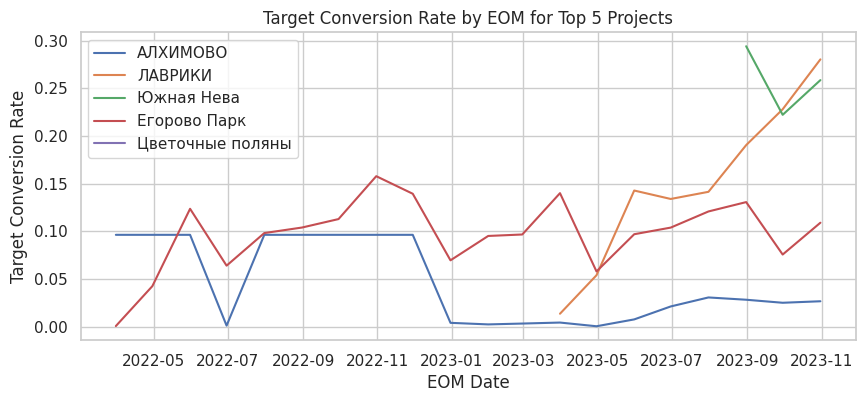

In [155]:
# Получаем список уникальных имен проектов
unique_projects = df['smt_name'].unique()

# Отбираем первые 5 проектов
top_projects = unique_projects[:5]

# Фильтруем DataFrame для отображения данных только для первых 5 проектов
top_projects_df = df[df['smt_name'].isin(top_projects)]

# Установка стиля для графиков (необязательно)
sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(10, 4))

# Цикл по каждому из пяти проектов для отдельного отображения на графике
for project in top_projects:
    # Фильтрация DataFrame для каждого проекта
    project_df = top_projects_df[top_projects_df['smt_name'] == project]

    # Сортировка данных по дате 'eom' для линейной визуализации по времени
    project_df = project_df.sort_values('eom')

    # Визуализация линейного графика для текущего проекта
    plt.plot(project_df['eom'], project_df['target_conversion_rate'], label=project)

# Подписи к графику
plt.xlabel('EOM Date')
plt.ylabel('Target Conversion Rate')
plt.title('Target Conversion Rate by EOM for Top 5 Projects')

# Добавление легенды
plt.legend()

# Отображение графика
plt.show()

На графике ниже можно видеть сравнеие target_conversion_rate и conversion_current. Разница тут возникает из-за разных дат определения этих двух показателей. Один из них определяется на 20 число месяца, один на конец месяца.
Но при этом target_conversion_rate это процент конверсии на следующий месяц.
Поэтому на графике эти два показателя как бы следуют друг за другом но не в точности.


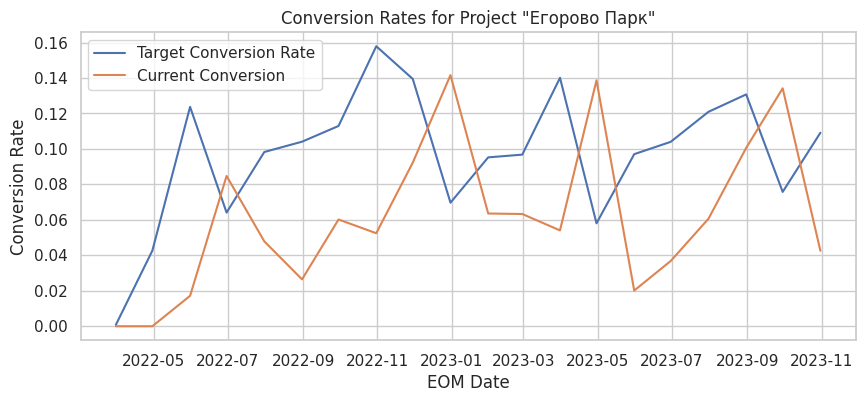

In [156]:
# Filter the DataFrame for the project "Егорово Парк"
project_df = df[df['smt_name'] == "Егорово Парк"]

# Sort the data by 'eom' for time series visualization
project_df = project_df.sort_values('eom')

# Create a new figure
plt.figure(figsize=(10, 4))

# Plot the 'target_conversion_rate' data
plt.plot(project_df['eom'], project_df['target_conversion_rate'], label='Target Conversion Rate')

# Plot the 'conversion_current' data
plt.plot(project_df['eom'], project_df['conversion_current'], label='Current Conversion')

# Add labels and title
plt.xlabel('EOM Date')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates for Project "Егорово Парк"')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Обработка данных по проектам
В данном блоке кода выполняется итерация по уникальным проектам в датасете `df`. Для каждого проекта, идентифицируемого с помощью колонки `project_id`, выполняются следующие шаги:

1. **Группировка данных**: Датасет `df` группируется по `project_id`, что позволяет работать с данными, относящимися к отдельному проекту.

2. **Обработка отдельных групп данных**: Для каждой группы данных (каждого проекта) создаются лагированные признаки (задержки, отставания временных рядов) с использованием функции `create_lagged_features`. Это может быть полезно для задач прогнозирования временных рядов, где предыдущие значения ряда используются для прогноза будущих.

3. **Сохранение результатов**: Обработанные данные для каждого проекта сохраняются в словаре `project_data`, а созданные модели (не показаны в примере) могут быть сохранены в словаре `project_models`.

Этот подход позволяет индивидуально анализировать и моделировать данные для каждого проекта в рамках единого датасета.

In [157]:
# Подготовка функции для создания лагов временного ряда
def create_lagged_features(df, n_lags=6):
    df_lagged = df.copy()
    for i in range(1, n_lags + 1):
        df_lagged[f'target_conversion_rate_lag_{i}'] = df['target_conversion_rate'].shift(i)
    df_lagged = df_lagged.dropna(how='all')  # Удаление строк с отсутствующими значениями из-за сдвига
    df_lagged = df_lagged.fillna('')  # Замена NaN на пустую строку

    # Удаление столбцов 'Unnamed: 0' и 'smt_construction_projectid'
    # df_lagged = df_lagged.drop(columns=['Unnamed: 0', 'smt_construction_projectid', 'smt_name', 'eom', 'smt_region_name'])
    df_lagged = df_lagged.drop(columns=['Unnamed: 0', 'smt_construction_projectid', 'eom', 'smt_region_name'])

    # Преобразование столбца 'start_date' в формат datetime
    df_lagged['start_date'] = pd.to_datetime(df_lagged['start_date'])

    # Создание копии DataFrame для дефрагментации
    df_lagged = df_lagged.copy()

    # Вычисление разницы между сегодняшней датой и датами в столбце 'start_date'
    df_lagged['days_since_start'] = (datetime.now() - df_lagged['start_date']).dt.days

    # Удаление столбца 'start_date'
    df_lagged = df_lagged.drop(columns=['start_date'])

    # Преобразование столбцов в числовые значения
    cols_to_convert = ['expon_secondary__g_project__area__radius_500m__sum__0M',
                       'expon_secondary__g_project__area__radius_1km__sum__0M',
                       'expon_secondary__g_project__area__radius_3km__sum__0M',
                       'expon_secondary__g_project__area__radius_500m__avg__0M',
                       'expon_secondary__g_project__area__radius_1km__avg__0M',
                       'expon_secondary__g_project__area__radius_3km__avg__0M',
                       'expon_secondary__g_project__price_m__radius_500m__sum__0M',
                       'expon_secondary__g_project__price_m__radius_1km__sum__0M',
                       'expon_secondary__g_project__price_m__radius_3km__sum__0M',
                       'expon_secondary__g_project__price_m__radius_500m__avg__0M',
                       'expon_secondary__g_project__price_m__radius_1km__avg__0M',
                       'expon_secondary__g_project__price_m__radius_3km__avg__0M',
                       'target_conversion_rate_lag_1',
                       'target_conversion_rate_lag_2', 'target_conversion_rate_lag_3',
                       'target_conversion_rate_lag_4', 'target_conversion_rate_lag_5',
                       'target_conversion_rate_lag_6']
    for col in cols_to_convert:
        df_lagged[col] = pd.to_numeric(df_lagged[col], errors='coerce')

    # Преобразование 'updated_dt' в числовое значение
    df_lagged['updated_dt'] = pd.to_datetime(df_lagged['updated_dt'])
    df_lagged['days_since_updated'] = (datetime.now() - df_lagged['updated_dt']).dt.days
    df_lagged = df_lagged.drop(columns=['updated_dt'])

    df_lagged = df_lagged.fillna(0)  # Замена NaN на пустую строку

    return df_lagged

In [158]:
# Проверка работы функции
project_data_PRE = {}    # Словарь для хранения данных каждого проекта

# Цикл по каждому из проектов для отдельного отображения на графике
for project in unique_projects:
    # Фильтрация DataFrame для каждого проекта
    project_df = df[df['smt_name'] == project]

    # Сортировка данных по дате 'eom' для линейной визуализации по времени
    project_df = project_df.sort_values('eom')

    # Создание лагов временного ряда
    project_df = create_lagged_features(project_df)

    # Сохранение данных в словарь
    project_data_PRE[project] = project_df

    non_numeric_columns = project_data_PRE[project].select_dtypes(exclude=['int', 'float']).columns
    # print(non_numeric_columns)

# вывести данные для первого в списке проекта
project_data_PRE[unique_projects[1]].head()

,num_expon_apps,num_apps,num_expon_apps_0,num_expon_apps_1,num_expon_apps_2,num_expon_apps_3plus,num_apps_0,num_apps_1,num_apps_2,num_apps_3plus,...,target_conversion_rate,conversion_current,target_conversion_rate_lag_1,target_conversion_rate_lag_2,target_conversion_rate_lag_3,target_conversion_rate_lag_4,target_conversion_rate_lag_5,target_conversion_rate_lag_6,days_since_start,days_since_updated
20,19,67,0,10,6,3,0,39,16,12,...,0.013699,0.071429,0.000000,0.000000,0.000000,0.000000,0.0,0.0,605,442
21,29,251,0,15,7,7,0,121,86,64,...,0.054054,0.000000,0.013699,0.000000,0.000000,0.000000,0.0,0.0,605,412
22,130,402,0,38,53,34,0,171,158,120,...,0.142857,0.043478,0.054054,0.013699,0.000000,0.000000,0.0,0.0,605,381
23,157,411,0,58,56,39,0,197,160,123,...,0.134021,0.050000,0.142857,0.054054,0.013699,0.000000,0.0,0.0,605,351
24,190,435,0,94,57,36,0,232,160,109,...,0.141509,0.109375,0.134021,0.142857,0.054054,0.013699,0.0,0.0,605,320


In [159]:
# from itertools import islice

# # project_data_PRE — ваш словарь
# n_items = 1  # количество элементов, которые вы хотите вывести
# for key, value in islice(project_data_PRE.items(), n_items):
#     print(key, value)

In [160]:
# df.head()

### Подготовка временных рядов
В данном блоке кода расчитаем и добавим в датафрейм новые признаки.
Признаки будут расчитаны из существующего датафрейма.

Данные в датафрейме организованы следующим образом:
1. EOM (30.09.2022) - Проект1 - множество признаков - целевая переменная
2. EOM (31.10.2022) - Проект1 - множество признаков - целевая переменная
2. EOM (30.11.2022) - Проект1 - множество признаков - целевая переменная
2. EOM (30.09.2022) - *Проект2* - множество признаков - целевая переменная
2. EOM (31.10.2022) - *Проект2* - множество признаков - целевая переменная
2. EOM (30.11.2022) - *Проект2* - множество признаков - целевая переменная

и т.д.

Таким образом в каждой строке наблюдения в изначальном датафрейме не содержится информации за предыдущие периодны. Однако эта инфомрация доступна и может быть очень полезной. Поэтому ее нужно добавить к каждой строке, то есть добавить значения текущей конверсии за предыдущие месяца.
Выберем добавить в каждое наблюдение данные за 6 предыдущих месяцев.
Получим новые столбцы - "-1", "-2", "-3", "-4", "-5", "-6".

Затем добавим еще два столбца:
*Средняя конверсия за предыдущие 6 месяцев*
*Средняя конверсия за предыдущие 3 месяца*

In [161]:
def prepare_time_series(df):
    time_series_dict = {}
    smt_names = df['smt_name'].unique()
    end_date = pd.to_datetime('2023-11-30')

    for smt_name in smt_names:
        df_smt = df[df['smt_name'] == smt_name][['eom', 'target_conversion_rate']].copy()
        df_smt['eom'] = pd.to_datetime(df_smt['eom'])
        df_smt.dropna(subset=['eom'], inplace=True)

        if df_smt.empty:
            continue

        df_smt = df_smt.sort_values('eom')
        df_smt.set_index('eom', inplace=True)
        date_range = pd.date_range(start=df_smt.index.min(), end=end_date, freq='M')
        df_smt = df_smt.reindex(date_range)
        df_smt['target_conversion_rate'].fillna(0, inplace=True)
        df_smt.reset_index(inplace=True)
        df_smt.rename(columns={'index': 'eom'}, inplace=True)
        df_smt['eom'] = df_smt['eom'].dt.strftime('%Y-%m-%d')
        time_series_dict[smt_name] = pd.Series(df_smt.target_conversion_rate.values,index=df_smt.eom).to_dict()

    return time_series_dict

time_series_dict_smt = prepare_time_series(df)

In [162]:
print(time_series_dict_smt)

{'АЛХИМОВО': {'2022-03-31': 0.0964255254491894, '2022-04-30': 0.0964255254491894, '2022-05-31': 0.0964255254491894, '2022-06-30': 0.001224739742804654, '2022-07-31': 0.0964255254491894, '2022-08-31': 0.0964255254491894, '2022-09-30': 0.0964255254491894, '2022-10-31': 0.0964255254491894, '2022-11-30': 0.0964255254491894, '2022-12-31': 0.004156275976724855, '2023-01-31': 0.002510460251046025, '2023-02-28': 0.003399048266485384, '2023-03-31': 0.004444444444444444, '2023-04-30': 0.0005747126436781609, '2023-05-31': 0.007751937984496124, '2023-06-30': 0.0213351686166552, '2023-07-31': 0.03076923076923077, '2023-08-31': 0.02836879432624113, '2023-09-30': 0.0251937984496124, '2023-10-31': 0.02677459526774595, '2023-11-30': 0.0}, 'ЛАВРИКИ': {'2023-03-31': 0.0136986301369863, '2023-04-30': 0.05405405405405406, '2023-05-31': 0.1428571428571428, '2023-06-30': 0.134020618556701, '2023-07-31': 0.1415094339622641, '2023-08-31': 0.1904761904761905, '2023-09-30': 0.2280701754385965, '2023-10-31': 0.28

In [163]:
# преобразование словаря в df
df_time_series_dict_smt = pd.DataFrame(time_series_dict_smt)

# сохранение df в xls
df_time_series_dict_smt.to_excel(f"{folder_path}df_time_series_dict_smt.xlsx", index=False)

In [164]:
df.head(2)

,Unnamed: 0,smt_construction_projectid,eom,num_expon_apps,num_apps,num_expon_apps_0,num_expon_apps_1,num_expon_apps_2,num_expon_apps_3plus,num_apps_0,...,target_calls_qty_T1,target_deals_qty_T1,smt_name,smt_region_name,plan_area,meetings_qty,agent_meetings_qty,deals,target_conversion_rate,conversion_current
0,7,07091659-2705-E911-80E5-005056B8D207,2022-03-31,1690,1698,0,567,803,242,0,...,918.0,38.357616,АЛХИМОВО,Москва,4346.03,604.0,47.0,16.640884,0.096426,0.0
1,8,07091659-2705-E911-80E5-005056B8D207,2022-04-30,1326,1686,0,486,542,194,0,...,1029.0,38.357616,АЛХИМОВО,Москва,4148.49,634.0,21.0,16.640884,0.096426,0.0


In [165]:
import itertools

# Print the first 5 items
for key, value in itertools.islice(time_series_dict_smt.items(), 5):
    print(f"{key}: {value}")

АЛХИМОВО: {'2022-03-31': 0.0964255254491894, '2022-04-30': 0.0964255254491894, '2022-05-31': 0.0964255254491894, '2022-06-30': 0.001224739742804654, '2022-07-31': 0.0964255254491894, '2022-08-31': 0.0964255254491894, '2022-09-30': 0.0964255254491894, '2022-10-31': 0.0964255254491894, '2022-11-30': 0.0964255254491894, '2022-12-31': 0.004156275976724855, '2023-01-31': 0.002510460251046025, '2023-02-28': 0.003399048266485384, '2023-03-31': 0.004444444444444444, '2023-04-30': 0.0005747126436781609, '2023-05-31': 0.007751937984496124, '2023-06-30': 0.0213351686166552, '2023-07-31': 0.03076923076923077, '2023-08-31': 0.02836879432624113, '2023-09-30': 0.0251937984496124, '2023-10-31': 0.02677459526774595, '2023-11-30': 0.0}
ЛАВРИКИ: {'2023-03-31': 0.0136986301369863, '2023-04-30': 0.05405405405405406, '2023-05-31': 0.1428571428571428, '2023-06-30': 0.134020618556701, '2023-07-31': 0.1415094339622641, '2023-08-31': 0.1904761904761905, '2023-09-30': 0.2280701754385965, '2023-10-31': 0.28037383

In [166]:
df.head(2)

,Unnamed: 0,smt_construction_projectid,eom,num_expon_apps,num_apps,num_expon_apps_0,num_expon_apps_1,num_expon_apps_2,num_expon_apps_3plus,num_apps_0,...,target_calls_qty_T1,target_deals_qty_T1,smt_name,smt_region_name,plan_area,meetings_qty,agent_meetings_qty,deals,target_conversion_rate,conversion_current
0,7,07091659-2705-E911-80E5-005056B8D207,2022-03-31,1690,1698,0,567,803,242,0,...,918.0,38.357616,АЛХИМОВО,Москва,4346.03,604.0,47.0,16.640884,0.096426,0.0
1,8,07091659-2705-E911-80E5-005056B8D207,2022-04-30,1326,1686,0,486,542,194,0,...,1029.0,38.357616,АЛХИМОВО,Москва,4148.49,634.0,21.0,16.640884,0.096426,0.0


In [167]:
# Загрузите данные из файла CSV в DataFrame (например, df)
# df = pd.read_excel(f'{folder_path}df_final.xlsx')

def get_time_series_value(project_name, month_date):
    month_key = month_date  # month_date is already a string
    project_data = time_series_dict_smt.get(project_name, {})

    # print('Getting value for:', project_name, month_key)  # Print project_name and month_key

    month_value = None  # Initialize month_value as None

    if not project_data:
      # print(f"No data for project {project_name}")
      abcv= 1
    else:
      print('Project data:', project_data)  # Print project_data to verify it
      month_value = project_data.get(month_key, None)
      if month_value is None:
        print(f"No data for month {month_key} in project {project_name}")
      else:
        print(f"Data found - month: {month_key}, project: {project_name}, value: {month_value}")

    return month_value  # Return both month and value

In [168]:
# Добавляем столбцы в df для каждого из последних 6 месяцев от EOM
for i in range(1, 7):
    column_name = f"-{i}"
    df[column_name] = df.apply(lambda row: get_time_series_value(row['smt_name'],
                  (pd.to_datetime(row['eom']) - pd.DateOffset(months=i)).strftime("%Y-%m-%d")) or 0, axis=1)
# Результатом будет df, обновленный новыми столбцами (-1, -2, -3, -4, -5, -6),
# содержащими соответствующие значения временного ряда для каждого проекта

# Создаем новый порядок столбцов
cols = df.columns.tolist()
new_cols = cols[:-6] + cols[-1::-1][:6]

# Реорганизуем столбцы в DataFrame
df = df.reindex(columns=new_cols)

Выходные данные были обрезаны до нескольких последних строк (5000).
Project data: {'2022-03-31': 0.125, '2022-04-30': 0.09090909090909091, '2022-05-31': 0.0964255254491894, '2022-06-30': 0.0964255254491894, '2022-07-31': 0.0964255254491894, '2022-08-31': 0.01639344262295082, '2022-09-30': 0.01351351351351351, '2022-10-31': 0.03, '2022-11-30': 0.02884615384615385, '2022-12-31': 0.04347826086956522, '2023-01-31': 0.08737864077669903, '2023-02-28': 0.0, '2023-03-31': 0.1441441441441441, '2023-04-30': 0.03773584905660377, '2023-05-31': 0.08552631578947369, '2023-06-30': 0.04545454545454546, '2023-07-31': 0.01129943502824859, '2023-08-31': 0.04225352112676056, '2023-09-30': 0.03414634146341464, '2023-10-31': 0.08176100628930817, '2023-11-30': 0.0}
No data for month 2023-07-30 in project Верейская, 41
Project data: {'2022-03-31': 0.125, '2022-04-30': 0.09090909090909091, '2022-05-31': 0.0964255254491894, '2022-06-30': 0.0964255254491894, '2022-07-31': 0.0964255254491894, '2022-08-31': 0.0163

In [169]:
# df.head()

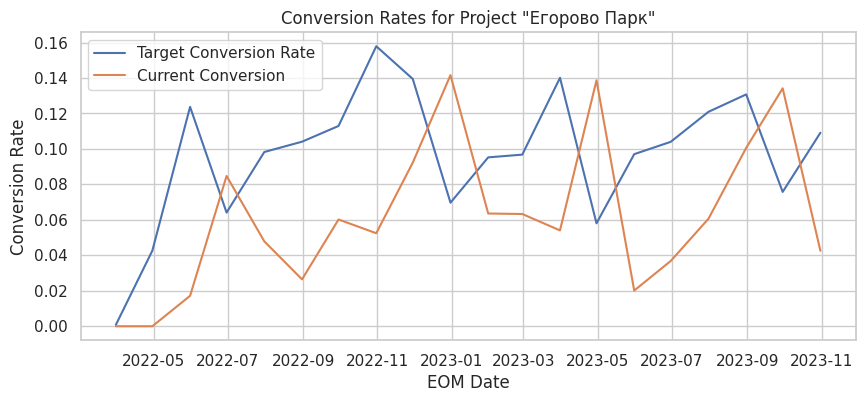

In [170]:
# Filter the DataFrame for the project "Егорово Парк"
project_df = df[df['smt_name'] == "Егорово Парк"]

# Sort the data by 'eom' for time series visualization
project_df = project_df.sort_values('eom')

# Create a new figure
plt.figure(figsize=(10, 4))

# Plot the 'target_conversion_rate' data
plt.plot(project_df['eom'], project_df['target_conversion_rate'], label='Target Conversion Rate')

# Plot the 'conversion_current' data
plt.plot(project_df['eom'], project_df['conversion_current'], label='Current Conversion')

# Add labels and title
plt.xlabel('EOM Date')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates for Project "Егорово Парк"')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [171]:
# df.head()

Итак мы получили датафрейм с добавленными столбцами (-1, -2, -3, -4, -5, -6) в которых записана конверсия соответствующего предществующего месяца.
То есть
-1 - конверсия на один месяц назад;
-2 - конверсия на два месяца назад;
и т.д.

In [172]:
# Вычисление среднего значения для столбцов (-1, -2, -3, -4, -5, -6) и добавление результата как новый столбец в df
df['average_last_6_months'] = df[['-1', '-2', '-3', '-4', '-5', '-5']].mean(axis=1)

# Вычисление среднего значения для столбцов (-1, -2, -3) и добавление результата как новый столбец в df
df['average_last_3_months'] = df[['-1', '-2', '-3']].mean(axis=1)

Теперь мы добавили два столбца со средними значениями конверсии за 3 месяца и за 6 месяцев.

### Обработка столбцов

In [173]:
# Предварительно убедитесь, что 'target_conversion_rate' в вашем DataFrame не содержит NaN
df['target_conversion_rate'].fillna(df['target_conversion_rate'].mean(), inplace=True)

# Применяем one-hot encoding к столбцу 'smt_construction_projectid'
df.drop('smt_construction_projectid', axis=1, inplace=True)

# Применяем one-hot encoding к столбцу 'smt_region_name'
df = pd.get_dummies(df, columns=['smt_region_name'])

#  Применяем one-hot encoding к столбцу 'smt_name'
df = pd.get_dummies(df, columns=['smt_name'])

# Удаление столбцов которые относятся к TARGET
df.drop(['target_deals_qty_T1'], axis=1, inplace=True)

# target_calls_qty_T1 не удаляем а сохраняем пока что для того чтобы использовать его в параметре sample_weight
# df.drop(['target_calls_qty_T1'], axis=1, inplace=True)

## Создадим дополнительные признаки

###*Добавим значение курса доллара.*

In [174]:
# import requests
# import xml.etree.ElementTree as ET

# def fetch_exchange_rate(date):
#     url = f'https://www.cbr.ru/scripts/XML_daily.asp?date_req={date.strftime("%d/%m/%Y")}'
#     response = requests.get(url)
#     root = ET.fromstring(response.content)

#     for valute in root.findall('Valute'):
#         # Ищем ID доллара, например, маркер для USD может быть 'R01235'
#         if valute.find('CharCode').text == 'USD':
#             exchange_rate = float(valute.find('Value').text.replace(',', '.'))
#             return exchange_rate

#     return None  # в случае если информация о USD не найдена

# df['Exchange_Rate'] = df['eom'].apply(fetch_exchange_rate)

### Добавим столбец месяца

*Столбец EOM нужно убрать, так как он будет являться подсказкой для модели. При этом при рабочем использовании данных за текущий месяц ни по каким другим проектам не будет. Таким образом этот признак будет только запутывать модель.*

*Однако мы можем сделать новый признак и оставить только значение месяца. Этот признак может отразить влияние сезонности или характеристику определенного месяца для любого года. Но не какого то конкретного месяца определенного года.*

*Добаим новый признак - month.*

In [175]:
import pandas as pd

# Убедимся, что 'eom' распознаётся как datetime
df['eom'] = pd.to_datetime(df['eom'])

# Создаем новый столбец 'month' путем извлечения месяца из 'eom'
df['month'] = df['eom'].dt.month

In [176]:
#  Применяем one-hot encoding к столбцу 'smt_name'
df_reserved2 = pd.get_dummies(df, columns=['month'])

In [177]:
df.drop('eom', axis=1, inplace=True)

In [178]:
# Сохраним промежуточный df
df.to_excel(f"{folder_path}df_middle1.xlsx", index=False)

## Вычислим корреляции

In [179]:
# Исключаем нечисловые столбцы перед вычислением корреляции
features_df = df.select_dtypes(include=[np.number]).drop(columns=['target_conversion_rate'])

# Вычисляем корреляцию каждого столбца с 'target_conversion_rate'
correlation_with_target = features_df.corrwith(df['target_conversion_rate'])

In [180]:
# Сортировка значений корреляций по убыванию
sorted_correlations = correlation_with_target.abs().sort_values(ascending=False)

In [181]:
print(sorted_correlations)

average_last_3_months                                             0.479961
-1                                                                0.428750
average_last_6_months                                             0.411436
-2                                                                0.409137
deals                                                             0.374554
                                                                    ...   
expon_secondary__g_project__price_m__radius_500m__avg__0M              NaN
expon_secondary__g_project__price_m__radius_1km__avg__0M               NaN
expon_secondary__g_project__price_m__radius_3km__avg__0M               NaN
house_info__g_house__finish_type_eq_pozhelaniyuzakazchika__avg         NaN
conversion_current                                                     NaN
Length: 747, dtype: float64


In [182]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Расчет матрицы корреляций
correlation_matrix = df.corr()

In [183]:
# save df as xls file
df.to_excel(f"{folder_path}df_reserved.xlsx", index=False)
df_reserved = df.copy()

In [184]:
# Отбросим столбцы, у которых корелляция с target меньше определенного процента

# Список фичей для удаления
features_to_drop = []

# Итерация по корреляциям
for feature, correlation in sorted_correlations.items():
    # Если корреляция меньше определенного процента, то добавляем фичу в список для удаления
    if abs(correlation) < 0.13:
        features_to_drop.append(feature)

# Удаление фичей из DataFrame
sorted_correlations.drop(features_to_drop, inplace=True)

# Удаление столбцов, которые содержат NaN
sorted_correlations = sorted_correlations.dropna(how='any') # type: ignore

# Проверка размера Series
print(sorted_correlations.shape)

# Проверка типов элементов
print(sorted_correlations.dtypes)

(68,)
float64


In [185]:
print(sorted_correlations)

average_last_3_months                           0.479961
-1                                              0.428750
average_last_6_months                           0.411436
-2                                              0.409137
deals                                           0.374554
                                                  ...   
expon__g_house__price__rooms_2__min__1_2M       0.130973
expon__g_house__cost__rooms_3plus__max__1_3M    0.130564
expon__g_house__floor__min__1_1M                0.130402
expon_area                                      0.130306
expon__g_project__cost__rooms_0__max__1_1M      0.130022
Length: 68, dtype: float64


In [186]:
# Получаем список названий
column_names = sorted_correlations.index.tolist()

for name in column_names:
    print(name)

average_last_3_months
-1
average_last_6_months
-2
deals
-3
-4
datekey
house_id
project_id
target_calls_qty_T1
-5
month
primary_calls
secondary_calls
sold_price
mean_price
expon_secondary__g_project__area__radius_500m__sum__1M
expon__g_project__type_flats__avg__1_1M
expon__g_project__type_apartments__avg__1_1M
num_apps_0
expon__g_project__cost__rooms_1__max__1_1M
num_expon_apps
neighbours_info__g_house__first_floor_non_liv__radius_3km__avg
expon__g_house__price__rooms_2__max__1_3M
num_apps
expon__g_house__price__rooms_2__max__1_2M
expon__g_project__type_flats__avg__1_2M
expon__g_project__type_apartments__avg__1_2M
neighbours_info__g_house__days_to_finish__radius_3km__avg
expon__g_project__type_flats__avg__1_3M
expon__g_project__type_apartments__avg__1_3M
num_expon_apps_0
expon__g_project__cost__rooms_1__max__1_2M
expon__g_house__price__rooms_2__avg__1_2M
neighbours_info__g_house__flats_per_floor__radius_3km__avg
expon__g_house__price__rooms_2__avg__1_3M
expon__g_house__price__rooms_2__m

In [187]:
# Добавляем 'target_conversion_rate' в список, если его там еще нет
if 'target_conversion_rate' not in column_names:
    column_names.append('target_conversion_rate')

# Выбираем нужные столбцы из df_encoded
df = df[column_names]

In [188]:
# show shape of df_encoded
print(df.shape)

(620, 69)


### Матрица корреляций

In [189]:
# Расчет матрицы корреляций
correlation_matrix = df.corr()

# Настройка размеров графика. Значение figsize можно изменить, чтобы подстроить размер
plt.figure(figsize=(40, 30))

# Построение heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

# Отображение heatmap
plt.show()

Output hidden; open in https://colab.research.google.com to view.

На получивщейся матрице мы видим множество столбцов с очень высокой кореляцией, это означает, что признаки очень похожи и информация в них очень похожа либо повторяется.

Итак, будем почереди рассматривать пары признаков с кореляцией больше 80%. Будем из каждой пары убирать тот признак который менее скоррелирован с целевой переменной.

In [190]:
# # Убираем лишние столбцы
df.drop('-1', axis=1, inplace=True)
df.drop('-2', axis=1, inplace=True)
df.drop('-3', axis=1, inplace=True)
# df.drop('datekey', axis=1, inplace=True)  -- пока не убираю здесь для того чтобы потом выделить период для OOS
df.drop('average_last_6_months', axis=1, inplace=True)
df.drop('house_id', axis=1, inplace=True)
df.drop('secondary_calls', axis=1, inplace=True)
df.drop('mean_price', axis=1, inplace=True)
df.drop('expon__g_project__type_apartments__avg__1_1M', axis=1, inplace=True)
df.drop('num_expon_apps', axis=1, inplace=True)
df.drop('expon__g_project__type_apartments__avg__1_2M', axis=1, inplace=True)
df.drop('expon__g_project__type_apartments__avg__1_3M', axis=1, inplace=True)
df.drop('expon__g_project__type_flats__avg__1_3M', axis=1, inplace=True)
df.drop('expon__g_house__type_apartments__avg__1_1M', axis=1, inplace=True)
df.drop('expon__g_house__type_flats__avg__1_1M', axis=1, inplace=True)
df.drop('expon__g_house__type_apartments__avg__1_2M', axis=1, inplace=True)
df.drop('expon__g_house__type_flats__avg__1_2M', axis=1, inplace=True)
df.drop('expon__g_house__type_apartments__avg__1_3M', axis=1, inplace=True)
df.drop('expon__g_house__type_flats__avg__1_3M', axis=1, inplace=True)
df.drop('expon__g_house__price__rooms_2__max__1_3M', axis=1, inplace=True)
df.drop('expon__g_house__price__rooms_2__max__1_2M', axis=1, inplace=True)
df.drop('expon__g_project__cost__rooms_1__max__1_2M', axis=1, inplace=True)
df.drop('expon__g_house__price__rooms_2__avg__1_2M', axis=1, inplace=True)
df.drop('neighbours_info__g_house__flats_per_floor__radius_3km__avg', axis=1, inplace=True)
df.drop('expon__g_house__price__rooms_2__avg__1_3M', axis=1, inplace=True)
df.drop('expon__g_house__price__rooms_2__max__1_1M', axis=1, inplace=True)
df.drop('expon__g_project__cost__rooms_0__avg__1_1M', axis=1, inplace=True)
df.drop('expon__g_house__price__avg__1_1M', axis=1, inplace=True)
df.drop('expon__g_house__price__min__1_1M', axis=1, inplace=True)
df.drop('expon__g_project__cost__rooms_1__max__1_3M', axis=1, inplace=True)
df.drop('expon__g_project__cost__rooms_0__avg__1_3M', axis=1, inplace=True)
df.drop('expon__g_house__cost__min__1_1M', axis=1, inplace=True)
df.drop('expon__g_project__type_flats__avg__1_2M', axis=1, inplace=True)
df.drop('expon__g_project__price__rooms_2__max__1_1M', axis=1, inplace=True)
df.drop('expon__g_house__cost__min__1_2M', axis=1, inplace=True)
df.drop('expon__g_house__price__min__1_2M', axis=1, inplace=True)
df.drop('expon__g_house__price__rooms_3plus__max__1_1M', axis=1, inplace=True)
df.drop('expon__g_project__cost__rooms_0__avg__1_2M', axis=1, inplace=True)
df.drop('expon__g_house__cost__min__1_3M', axis=1, inplace=True)
df.drop('expon__g_project__cost__rooms_2__max__1_1M', axis=1, inplace=True)
df.drop('expon__g_house__price__avg__1_2M', axis=1, inplace=True)
df.drop('expon__g_project__price__rooms_3plus__max__1_2M', axis=1, inplace=True)
df.drop('expon__g_project__price__rooms_3plus__max__1_3M', axis=1, inplace=True)
df.drop('expon__g_house__price__min__1_3M', axis=1, inplace=True)
df.drop('expon__g_project__price__rooms_3plus__max__1_1M', axis=1, inplace=True)
df.drop('expon__g_house__price__rooms_2__min__1_2M', axis=1, inplace=True)
df.drop('expon__g_house__cost__rooms_3plus__max__1_3M', axis=1, inplace=True)
df.drop('expon__g_house__floor__min__1_1M', axis=1, inplace=True)
df.drop('expon__g_project__cost__rooms_0__max__1_1M', axis=1, inplace=True)
df.drop('expon__g_project__type_flats__avg__1_1M', axis=1, inplace=True)

### Матрица с меньшим количеством признаков

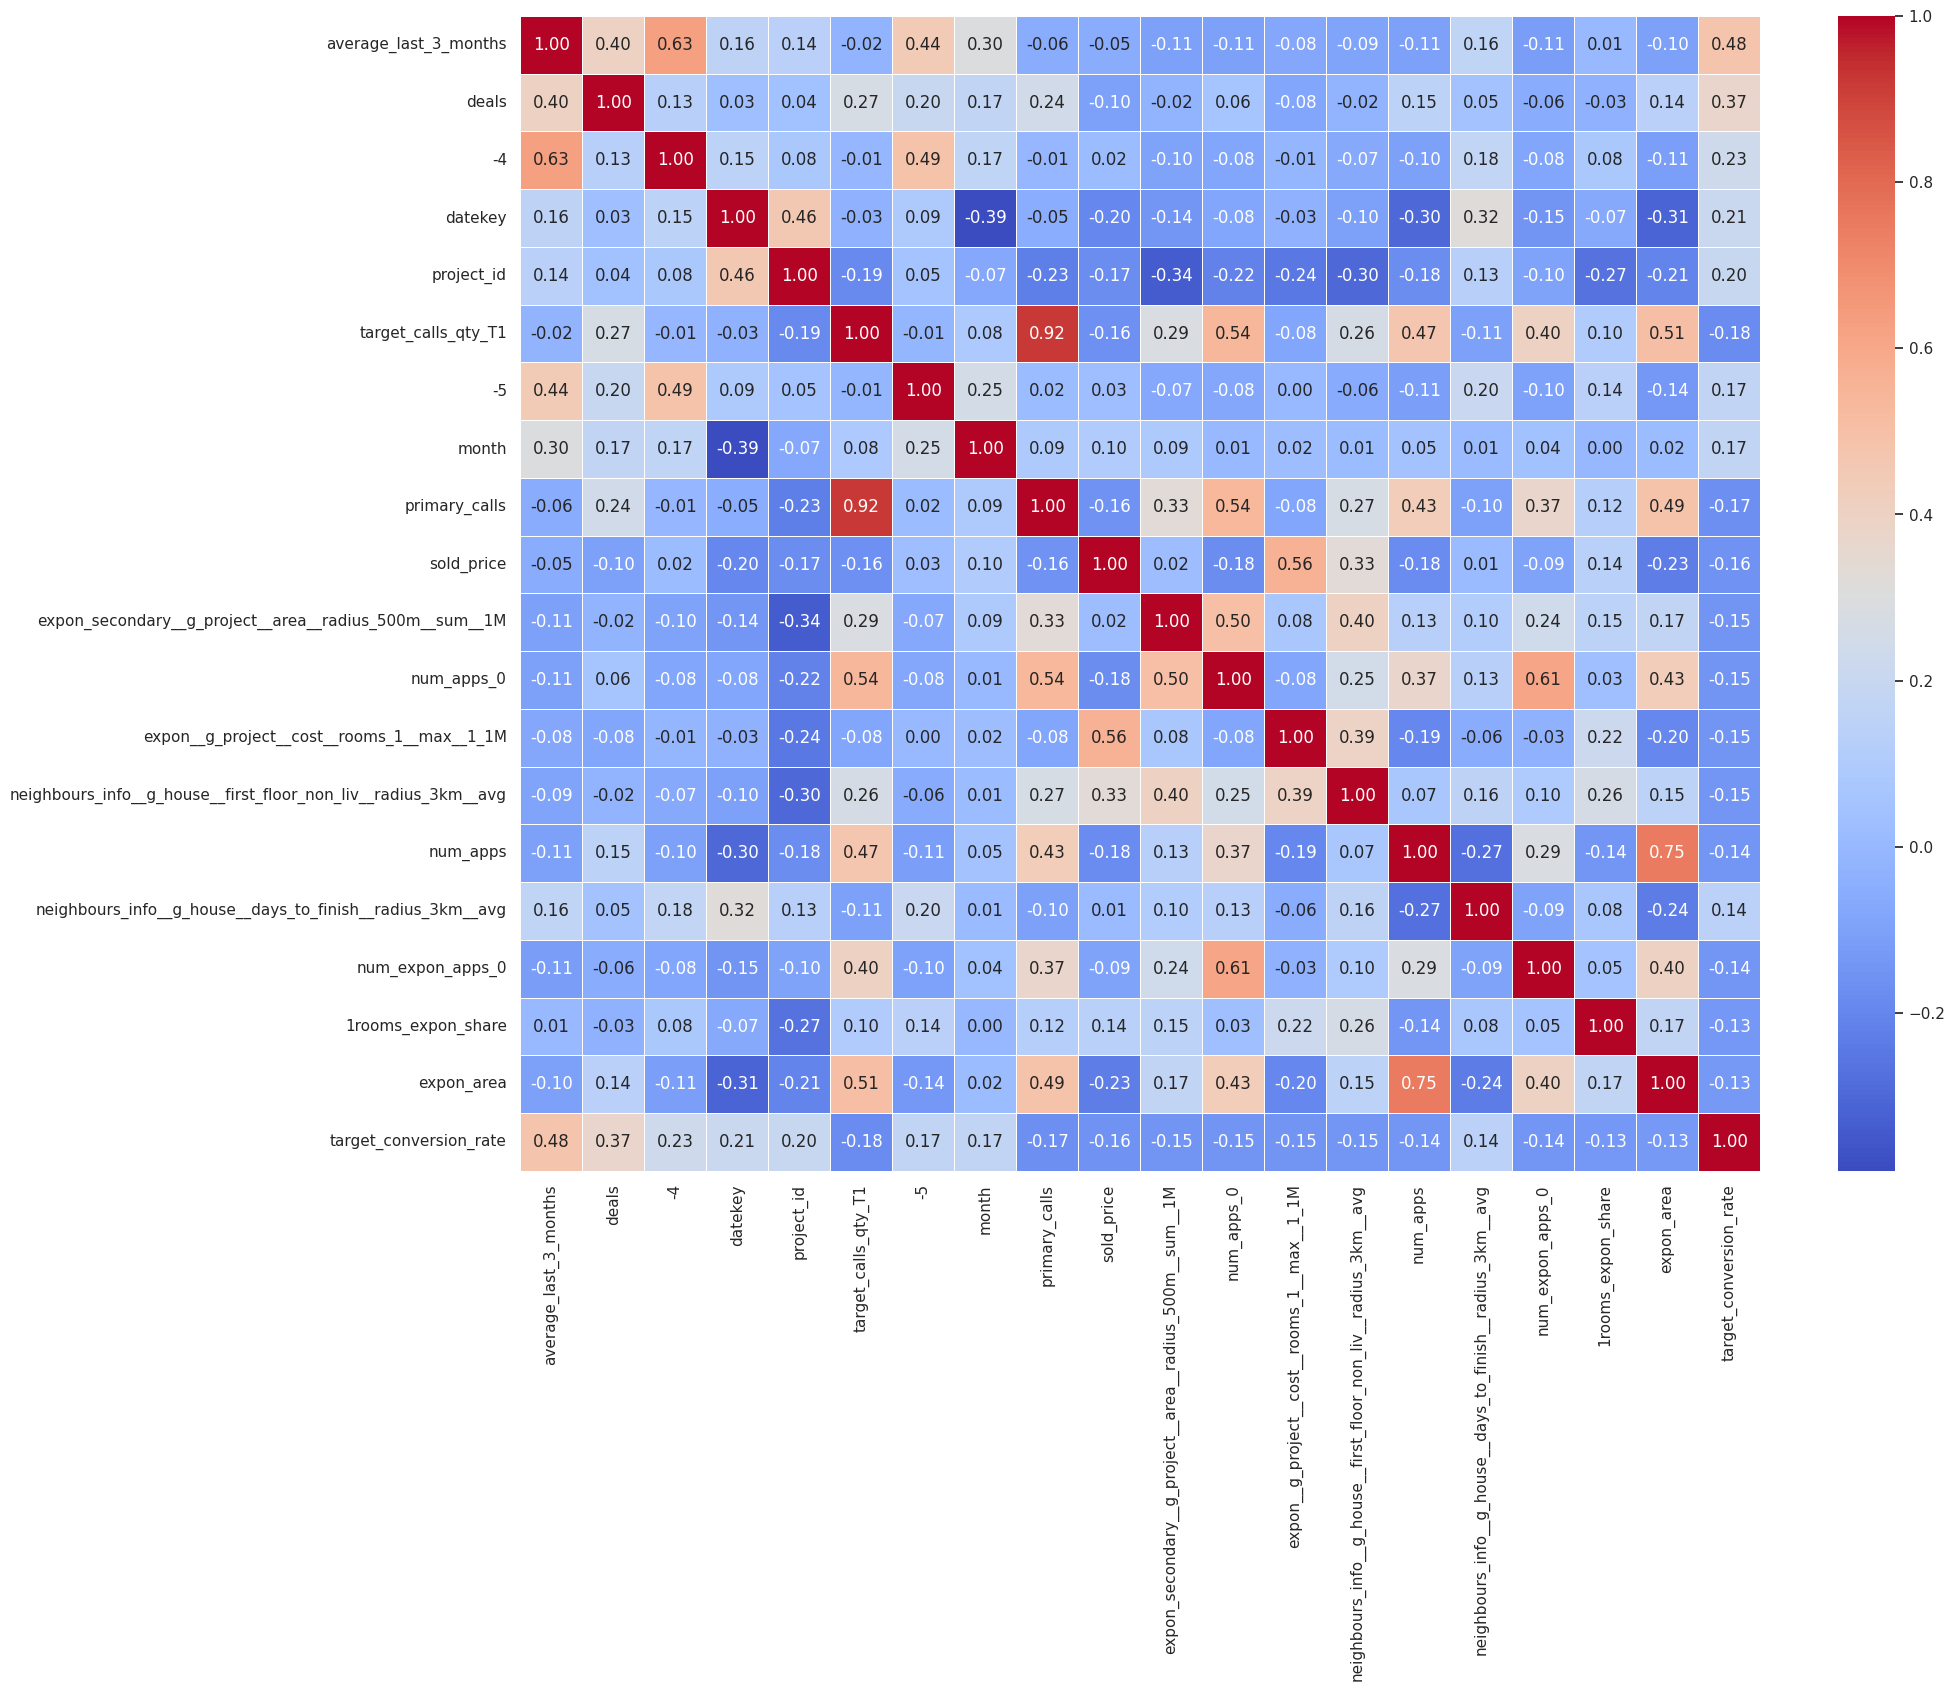

In [191]:
# Расчет матрицы корреляций
correlation_matrix = df.corr()

# Настройка размеров графика. Значение figsize можно изменить, чтобы подстроить размер
plt.figure(figsize=(20, 15))

# Построение heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

# Отображение heatmap
plt.show()

## Модели машинного обучения

### Модель RandomForestClassifier

In [231]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error

# Define target variable and features
X = df.drop(['target_conversion_rate', 'target_calls_qty_T1'], axis=1)
y = df['target_conversion_rate']
weights = df['target_calls_qty_T1']

# Convert datetime columns to numeric format
for col in X.columns:
    if X[col].dtype == 'datetime64':
        X[col] = X[col].astype('int64')

# Convert datetime columns to numeric format
for col in X.columns:
    if X[col].dtype == 'datetime64[ns]':
        X[col] = X[col].astype('int64')

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace missing values with column mean
X.fillna(X.mean(), inplace=True)

from sklearn.preprocessing import RobustScaler

# Apply RobustScaler scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)  # Convert back to DataFrame

# Split data into train and test sets
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_scaled, y, weights, test_size=0.2, random_state=42)

# Create and train the RandomForestRegressor model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train, sample_weight=weights_train)  # Use sample weights in training

# Predict on testing set
y_pred_rf = model_rf.predict(X_test)

# Calculate metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
evs_rf = explained_variance_score(y_test, y_pred_rf)
mape = mean_absolute_percentage_error(y_test, y_pred_rf)

# Print metrics
print('Random Forest - Mean squared error: ', mse_rf)
print('Random Forest - R2 score: ', r2_rf)
print('Random Forest - Explained variance score: {:.2%}'.format(evs_rf))
print(f"MAPE: {mape:.2f}%")

Random Forest - Mean squared error:  0.002169594159787538
Random Forest - R2 score:  0.5850631748725863
Random Forest - Explained variance score: 59.00%
MAPE: 2.08%


### Модель Catboost

CatBoost - Mean absolute error (MAE): 0.05%
CatBoost - R2 score: 0.14%
MAPE: 3.51%


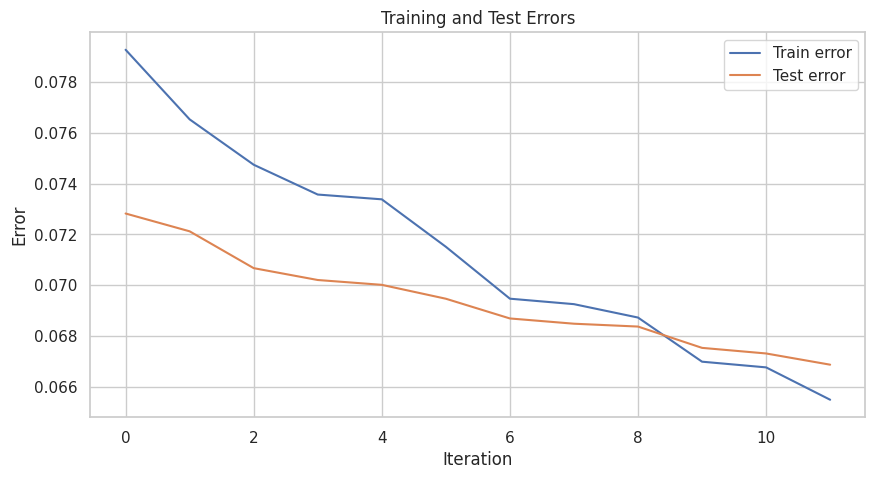

In [145]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define target variable and features
X = df.drop(['target_conversion_rate', 'target_calls_qty_T1', 'datekey'], axis=1)
y = df['target_conversion_rate']
weights = df['target_calls_qty_T1']

# Convert datetime columns to numeric format
for col in X.columns:
    if X[col].dtype == 'datetime64':
        X[col] = X[col].astype('int64')

# Convert datetime columns to numeric format
for col in X.columns:
    if X[col].dtype == 'datetime64[ns]':
        X[col] = X[col].astype('int64')

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace missing values with column mean
X.fillna(X.mean(), inplace=True)

from sklearn.preprocessing import RobustScaler

# Apply RobustScaler scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
 # Convert back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split data into train and test sets
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_scaled, y, weights, test_size=0.2, random_state=42)

# Define the CatBoostRegressor model
model = CatBoostRegressor(
    iterations=12,
    # iterations=1000,
    learning_rate=0.1,
    depth=3,
    loss_function='RMSE',
    eval_metric='R2',
    # verbose=100  # Will output training process information every 100 iterations
)

# Train the model
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,
    # Use sample weights in training
    sample_weight=weights_train,
    verbose=False
)

# Make prediction on the testing dataset
y_pred_cb = model.predict(X_test)

# Calculate performance metrics
mae_cb = mean_absolute_error(y_test, y_pred_cb)
r2_cb = r2_score(y_test, y_pred_cb)
mape_cb = mean_absolute_percentage_error(y_test, y_pred_cb)

# Print performance metrics
print(f"CatBoost - Mean absolute error (MAE): {mae_cb:.2f}%")
print(f"CatBoost - R2 score: {r2_cb:.2f}%")
print(f"MAPE: {mape_cb:.2f}%")

# Plot training error and test error
plt.figure(figsize=(10,5))
plt.plot(model.get_evals_result()['learn']['RMSE'], label='Train error')
plt.plot(model.get_evals_result()['validation']['RMSE'], label='Test error')
plt.title('Training and Test Errors')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

### Модель XGBoost

XGBoost - Mean absolute error (MAE): 0.04
XGBoost - R2 score: 0.54
MAPE: 2.29%


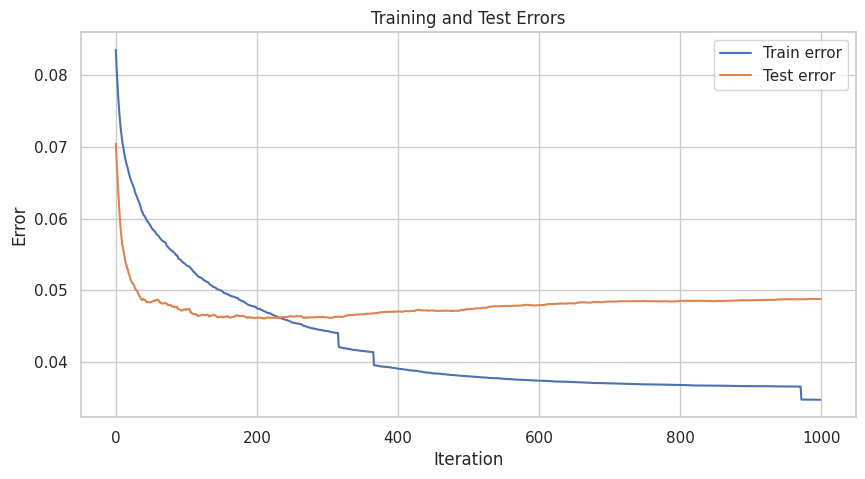

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler
import xgboost as xgb

# Define target variable and features
X = df.drop(['target_conversion_rate', 'target_calls_qty_T1'], axis=1)
y = df['target_conversion_rate']
weights = df['target_calls_qty_T1']

# Convert datetime columns to numeric format
for col in X.columns:
    if X[col].dtype == 'datetime64':
        X[col] = X[col].astype('int64')

# Convert datetime columns to numeric format (second version)
for col in X.columns:
    if X[col].dtype == 'datetime64[ns]':
        X[col] = X[col].astype('int64')

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace missing values with column mean
X.fillna(X.mean(), inplace=True)

# Apply RobustScaler scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
# Convert back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split data into train and test sets
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_scaled, y, weights, test_size=0.2, random_state=42)

# Define the XGBRegressor model
model = xgb.XGBRegressor(
    n_estimators=1000,  # Number of boosting rounds
    # n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    objective='reg:squarederror',  # Use squared error as loss function
    eval_metric='rmse',            # Use RMSE as evaluation metric
)

# Train the model directly using DataFrame or numpy arrays
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    sample_weight=weights_train,
    early_stopping_rounds=None, # 10,  # Stop training if validation metric doesn't improve for 10 consecutive rounds
    verbose=False  # Set to True to see training progress
)

# Make prediction on the testing dataset
y_pred_xgb = model.predict(X_test)

# Calculate performance metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

# Print performance metrics
print(f"XGBoost - Mean absolute error (MAE): {mae_xgb:.2f}")
print(f"XGBoost - R2 score: {r2_xgb:.2f}")
print(f"MAPE: {mape_xgb:.2f}%")

# Plot training error and test error
results = model.evals_result()
plt.figure(figsize=(10,5))
plt.plot(results['validation_0']['rmse'], label='Train error')
plt.plot(results['validation_1']['rmse'], label='Test error')
plt.title('Training and Test Errors')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

Здесь видно, что к тысячной эпохе модель уже давно переобучена. Переобучение начинается примерно с 220 эпохи. Поэтому в следующей итерации сократим обучение до 220 эпох.

XGBoost - Mean absolute error (MAE): 0.04
XGBoost - R2 score: 0.59
MAPE: 2.30%


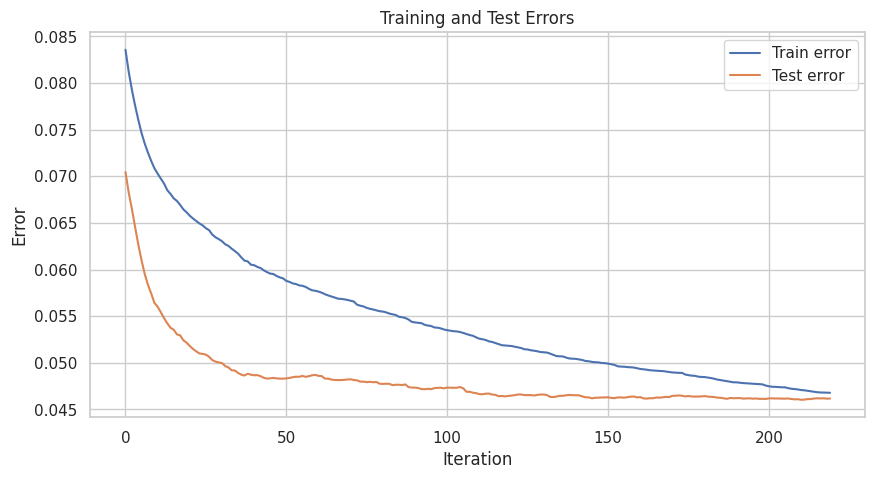

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler
import xgboost as xgb

# Define target variable and features
X = df.drop(['target_conversion_rate', 'target_calls_qty_T1'], axis=1)
y = df['target_conversion_rate']
weights = df['target_calls_qty_T1']

# Convert datetime columns to numeric format
for col in X.columns:
    if X[col].dtype == 'datetime64':
        X[col] = X[col].astype('int64')

# Convert datetime columns to numeric format (second version)
for col in X.columns:
    if X[col].dtype == 'datetime64[ns]':
        X[col] = X[col].astype('int64')

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace missing values with column mean
X.fillna(X.mean(), inplace=True)

# Apply RobustScaler scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
# Convert back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split data into train and test sets
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_scaled, y, weights, test_size=0.2, random_state=42)


# Define the XGBRegressor model
model = xgb.XGBRegressor(
    n_estimators=220,  # Number of boosting rounds
    # n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    objective='reg:squarederror',  # Use squared error as loss function
    eval_metric='rmse',            # Use RMSE as evaluation metric
)

# Train the model directly using DataFrame or numpy arrays
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    sample_weight=weights_train,
    early_stopping_rounds=None, # 10,  # Stop training if validation metric doesn't improve for 10 consecutive rounds
    verbose=False  # Set to True to see training progress
)

# Make prediction on the testing dataset
y_pred_xgb = model.predict(X_test)

# Calculate performance metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

# Print performance metrics
print(f"XGBoost - Mean absolute error (MAE): {mae_xgb:.2f}")
print(f"XGBoost - R2 score: {r2_xgb:.2f}")
print(f"MAPE: {mape_xgb:.2f}%")

# Plot training error and test error
results = model.evals_result()
plt.figure(figsize=(10,5))
plt.plot(results['validation_0']['rmse'], label='Train error')
plt.plot(results['validation_1']['rmse'], label='Test error')
plt.title('Training and Test Errors')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

### Модель LightGBM

LightGBM - Mean absolute error (MAE): 0.04
LightGBM - R2 score: 0.54
MAPE: 1.88%


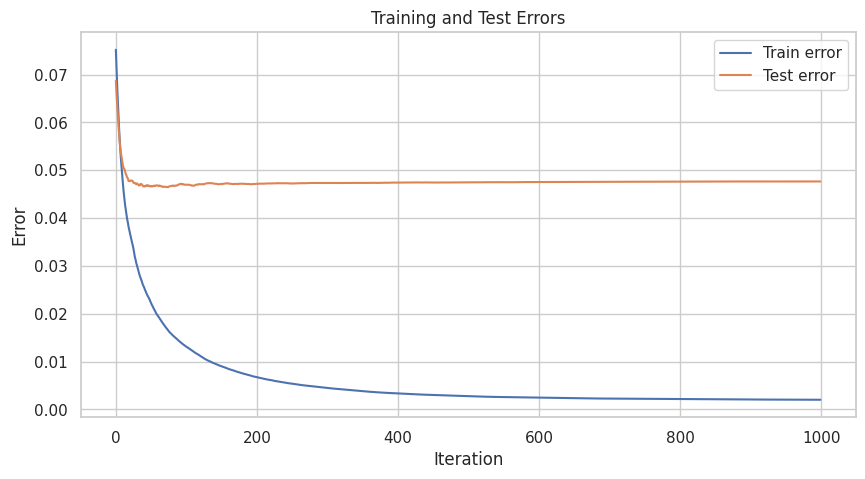

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb

# Define target variable and features
X = df.drop(['target_conversion_rate', 'target_calls_qty_T1'], axis=1)
y = df['target_conversion_rate']
weights = df['target_calls_qty_T1']

# Convert datetime columns to numeric format
for col in X.columns:
    if X[col].dtype == 'datetime64' or X[col].dtype == 'datetime64[ns]':
        X[col] = X[col].astype('int64')

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace missing values with column mean
X.fillna(X.mean(), inplace=True)

# Apply RobustScaler scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
# Convert back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split data into train and test sets
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_scaled, y, weights, test_size=0.2, random_state=42)


# Define the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train, weight=weights_train)
test_data = lgb.Dataset(X_test, label=y_test, weight=weights_test, reference=train_data)

# Define the parameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1
}

# Initialize list to store evaluation results
evals_result = {}

# Train the model with `lgb.record_evals()` callback to store evaluation results
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,  # Maximum number of boosting rounds
    valid_sets=[train_data, test_data],
    valid_names=['training', 'valid_1'],
    callbacks=[lgb.record_evaluation(evals_result)],
)

# Make prediction on the testing dataset
y_pred_lgb = model.predict(X_test, num_iteration=model.best_iteration)

# Calculate performance metrics
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
mape_lgb = np.mean(np.abs((y_test - y_pred_lgb) / y_test))

# Print performance metrics
print(f"LightGBM - Mean absolute error (MAE): {mae_lgb:.2f}")
print(f"LightGBM - R2 score: {r2_lgb:.2f}")
print(f"MAPE: {mape_lgb:.2f}%")

# Plot training error and test error
plt.figure(figsize=(10, 5))
plt.plot(evals_result['training']['rmse'], label='Train error')
plt.plot(evals_result['valid_1']['rmse'], label='Test error')
plt.title('Training and Test Errors')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

## Сравнение и выбор лучшей модели

Анализируя полученные метрики и кривые обучения можно увидеть, что для данной задачи больше всего подходит модель CatBoost.

LightGBM - можно сразу отбросить так как на графике кривых обучения мы видим сильное расхождение между тестовыми и тренировочными метриками.

Модели RandomForest, Catboost и XGBoost показывают сопоставимые метрики MAE и MAPE. Но при этом модель XGBoost показывает лучший результат на метрике R2.

R² (коэффициент детерминации) является одним из ключевых показателей, используемых для оценки качества модели. Он показывает, какая доля дисперсии зависимой переменной (то есть целевого значения) объясняется независимыми переменными (предикторами) модели. Значение R² варьируется от 0 до 1.

Таким образом, чем выше значение R², тем лучше модель объясняет вариации данных.

**Поэтому для данной задачи рекомендуется использовать XGBoost.**

## Дополнительная проверка на мультикллинеарность

In [51]:
# Объединение X_train и y_train в один DataFrame
train_df = X_train.copy()
train_df['target_conversion_rate'] = y_train.reset_index(drop=True)

# Для наглядности печатаем первые несколько строк
train_df.head(10)

,average_last_3_months,deals,-4,datekey,project_id,-5,month,primary_calls,sold_price,expon_secondary__g_project__area__radius_500m__sum__1M,num_apps_0,expon__g_project__cost__rooms_1__max__1_1M,neighbours_info__g_house__first_floor_non_liv__radius_3km__avg,num_apps,neighbours_info__g_house__days_to_finish__radius_3km__avg,num_expon_apps_0,1rooms_expon_share,expon_area,target_conversion_rate
531,-0.016387,0.000000,1.000000,0.501807,0.264135,-0.079593,-0.2,-0.196694,-0.791080,-1.540854,0.0,-1.505094,-2.233610,-0.000304,-0.958111,0.0,-0.614702,0.322943,NaN
364,-0.016387,-1.281931,0.300600,0.501807,-0.848615,-0.079593,-0.2,-0.474380,-0.793759,-0.868787,0.0,-1.855901,-1.149784,-0.463014,1.982063,0.0,0.203933,-0.268227,0.096426
177,-0.467089,0.000000,0.000000,0.459491,0.088045,-0.079593,-1.0,0.857851,0.372907,-2.120753,0.0,2.730763,-0.037437,0.715677,0.268179,0.0,0.194483,1.224104,0.001225
595,-0.467089,-0.812046,0.000000,0.480754,0.621953,0.219562,-0.6,-0.418182,1.978316,0.304974,0.0,2.358890,0.243705,0.143988,0.801008,0.0,-0.905919,-0.393564,NaN
199,-0.344087,-1.469886,0.000000,-0.550825,-0.917592,-0.079593,-0.2,-0.583471,5.386124,0.169495,0.0,0.000000,1.053994,-0.551294,-1.181982,0.0,0.894358,-0.219531,0.064327
421,0.885019,0.000000,1.000000,0.470333,0.001658,0.920407,-0.8,-0.586777,0.035904,-0.769614,0.0,-1.518370,-0.939395,-0.357078,1.501390,0.0,-1.589205,-0.517251,0.003106
300,-0.016387,-1.187954,1.000000,0.501807,0.608357,-0.079593,-0.2,0.229752,0.387106,-2.045779,0.0,0.206676,0.154820,1.090107,0.330320,0.0,-0.905556,-0.066423,0.318436
408,0.248358,-0.342160,0.724424,0.000000,-0.073023,0.225427,0.6,0.200000,0.369514,0.000000,2.0,0.000000,0.000000,0.494673,0.000000,0.0,-0.318405,-0.078499,0.008974
396,-0.235220,-1.281931,1.000000,-0.508614,-0.978776,0.920407,0.6,0.147107,0.809177,3.665528,2.0,3.545803,0.634562,1.421309,-1.653736,0.0,0.478713,0.926764,0.007519
286,-0.467089,0.000000,0.000000,-0.571877,-0.742663,-0.079593,-0.6,-0.176860,0.033796,-1.878756,0.0,0.027227,0.246683,2.679756,-0.871465,0.0,-0.640385,2.148699,0.003350


In [52]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Пример вычисления корреляционной матрицы
corr_matrix = X.corr()

# Визуализация корреляционной матрицы
import seaborn as sns
import matplotlib.pyplot as plt

# Функция для вычисления VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# Вычисление VIF
vif_data = calculate_vif(X)
print(vif_data)

                                             variable        VIF
0                               average_last_3_months   4.276632
1                                               deals   2.606985
2                                                  -4   2.928181
3                                             datekey  55.442610
4                                          project_id   6.839133
5                                                  -5   2.485958
6                                               month   7.017838
7                                       primary_calls   4.119667
8                                          sold_price  26.830074
9   expon_secondary__g_project__area__radius_500m_...   4.522315
10                                         num_apps_0   3.006536
11         expon__g_project__cost__rooms_1__max__1_1M  29.509417
12  neighbours_info__g_house__first_floor_non_liv_...  12.613190
13                                           num_apps   7.459181
14  neighbours_info__g_ho

**Теперь избавимся от мультиколлинеарных признаков, то есть от признаков VIF которых больше 10.**

*Пока что оставляем поле datekey, для того чтобы можно было отобрать выборку OOS по периоду.
Но уберем datekey при разделении на train и test, то есть перед началом обучения.*

In [53]:
# df.drop('datekey', axis=1, inplace=True) -- datekeay пока оставляю, для того чтобы можно было отобрать выборку OOS по периоду.
# но я убираю datekey при разделении на train и test.

In [54]:
df.drop('expon__g_project__cost__rooms_1__max__1_1M', axis=1, inplace=True)

In [55]:
df.drop('neighbours_info__g_house__first_floor_non_liv__radius_3km__avg', axis=1, inplace=True)

In [56]:
df.drop('sold_price', axis=1, inplace=True)

XGBoost - Mean absolute error (MAE): 0.04
XGBoost - R2 score: 0.48
XGBoost - MAPE: 2.77%


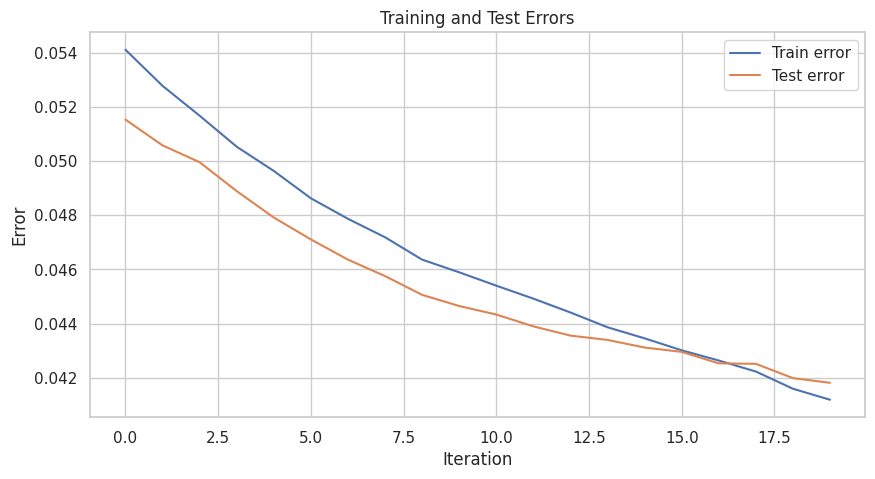

In [205]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Определим переменные целевые и признаки
X = df.drop(['target_conversion_rate', 'target_calls_qty_T1'], axis=1)
y = df['target_conversion_rate']
weights = df['target_calls_qty_T1']

# Преобразуем столбцы datetime в числовой формат
for col in X.columns:
    if X[col].dtype == 'datetime64':
        X[col] = X[col].astype('int64')

# Преобразуем столбцы datetime в числовой формат
for col in X.columns:
    if X[col].dtype == 'datetime64[ns]':
        X[col] = X[col].astype('int64')

# Заменим бесконечные значения на NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Заменим пропущенные значения средним по столбцу
X.fillna(X.mean(), inplace=True)

from sklearn.preprocessing import RobustScaler

# Применим масштабирование RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
# Преобразуем назад в DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Разделим данные на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_scaled, y, weights, test_size=0.2, random_state=42)

# Определим модель XGBRegressor
model = XGBRegressor(
    n_estimators=20,        # Количество итераций, аналогично iterations в CatBoost
    learning_rate=0.1,      # Скорость обучения
    max_depth=3,            # Глубина дерева
    objective='reg:squarederror',
    eval_metric='mae'
)

# Обучение модели
model.fit(
    X_train, y_train,
    sample_weight=weights_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Прогнозирование на тестовом наборе данных
y_pred_xgb = model.predict(X_test)

# Вычисление метрик производительности
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test))

# Печать метрик производительности
print(f"XGBoost - Mean absolute error (MAE): {mae_xgb:.2f}")
print(f"XGBoost - R2 score: {r2_xgb:.2f}")
print(f"XGBoost - MAPE: {mape_xgb:.2f}%")

# Построение графика ошибок обучения и тестирования
results = model.evals_result()
plt.figure(figsize=(10,5))
plt.plot(results['validation_0']['mae'], label='Train error')
plt.plot(results['validation_1']['mae'], label='Test error')
plt.title('Training and Test Errors')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 17 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   average_last_3_months                                      620 non-null    float64
 1   deals                                                      620 non-null    float64
 2   -4                                                         620 non-null    float64
 3   datekey                                                    620 non-null    float64
 4   project_id                                                 620 non-null    float64
 5   target_calls_qty_T1                                        620 non-null    float64
 6   -5                                                         620 non-null    float64
 7   month                                                      620 non-null    int32  
 8   primary_ca

Дополнительно проверим, что в X_tain нет каких то лишних столбцов, которых там не должно быть и которые могли бы быть подсказкой для модели.

In [59]:
# Объединение X_train и y_train в один DataFrame
train_df = X_scaled.copy()
train_df['target_conversion_rate'] = y.reset_index(drop=True)

# Для наглядности печатаем первые несколько строк
train_df.head(10)

,average_last_3_months,deals,-4,datekey,project_id,-5,month,primary_calls,expon_secondary__g_project__area__radius_500m__sum__1M,num_apps_0,num_apps,neighbours_info__g_house__days_to_finish__radius_3km__avg,num_expon_apps_0,1rooms_expon_share,expon_area,target_conversion_rate
0,-0.467089,0.000000,0.000000,-0.582298,-0.930691,-0.079593,-0.8,0.507438,-0.944477,0.0,0.296195,-1.776092,0.0,0.109126,1.670781,0.096426
1,-0.467089,0.000000,0.000000,-0.571877,-0.930691,-0.079593,-0.6,0.976860,-0.039816,0.0,0.288889,-1.689888,0.0,0.337247,1.162711,0.096426
2,0.434316,0.000000,0.000000,-0.561246,-0.930691,-0.079593,-0.4,1.614876,-0.105511,0.0,0.253577,-1.600810,0.0,0.408152,0.918835,0.096426
3,-0.016387,0.000000,0.000000,-0.550825,-0.930691,-0.079593,-0.2,2.626446,0.078652,0.0,0.178082,-1.514606,0.0,0.615918,0.679034,0.001225
4,0.440041,-1.469886,1.000000,-0.540193,-0.930691,-0.079593,0.0,3.076033,-0.272443,0.0,0.117808,-1.425529,0.0,1.077912,0.640354,0.096426
5,0.440041,0.000000,1.000000,-0.529667,-0.930691,0.920407,0.2,2.523967,-0.484608,0.0,0.061796,-1.336451,0.0,1.173969,0.528219,0.096426
6,-0.461365,0.000000,0.000000,-0.519246,-0.930691,0.920407,0.4,1.727273,-0.550303,0.0,0.005175,-1.250247,0.0,1.171145,0.370381,0.096426
7,0.885019,0.000000,0.012701,-0.508614,0.028188,0.920407,0.6,1.238017,-0.490531,0.0,0.783257,-1.161170,0.0,-0.162960,0.364745,0.096426
8,-0.016387,0.000000,0.000000,-0.498193,-0.930691,-0.066892,0.8,2.609917,-0.116820,0.0,0.547032,-1.074966,0.0,-0.084542,0.444141,0.096426
9,0.885019,0.000000,1.000000,-0.487561,0.028188,0.920407,1.0,2.742149,0.381283,0.0,0.358295,-0.985888,0.0,-0.104501,0.318028,0.004156


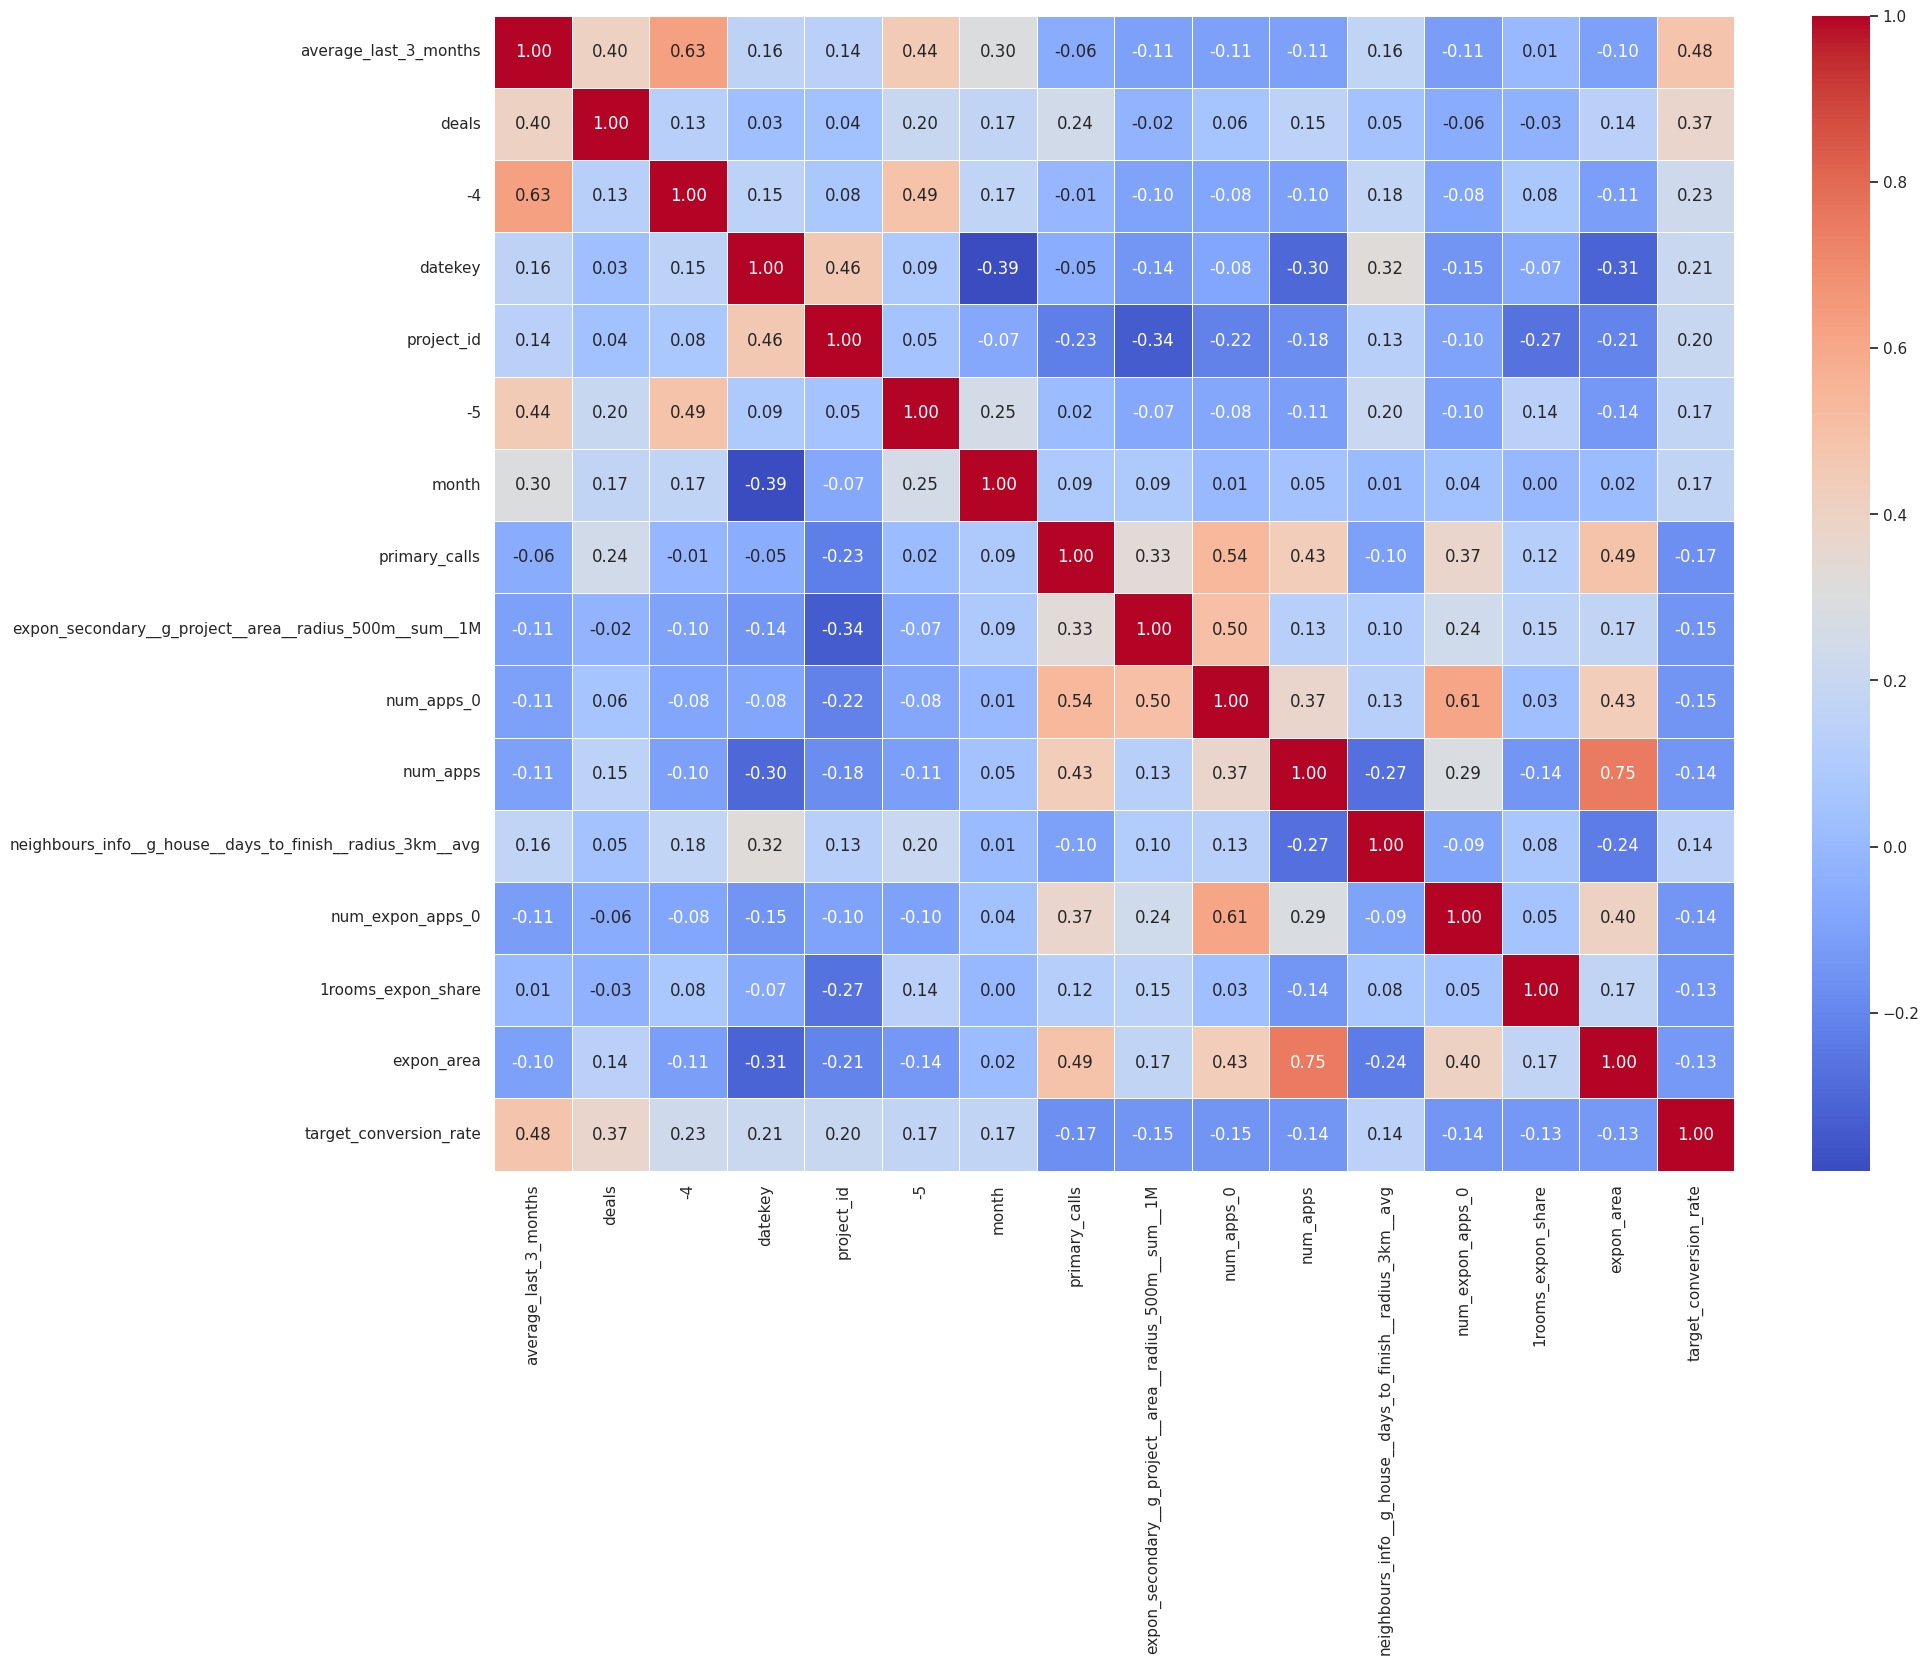

In [60]:
# Расчет матрицы корреляций
correlation_matrix = train_df.corr()

# Настройка размеров графика. Значение figsize можно изменить, чтобы подстроить размер
plt.figure(figsize=(20, 15))

# Построение heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

# Отображение heatmap
plt.show()

На матрице корреляций видим, что все признаки имеют корреляцию менее 76%.

Выведем еще раз показатели VIF для того чтобы проверить, что не осталось признаков в большими VIF значениями.

При этом учитываем что datekey временно оставляем для того, чтобы в дальнейшем по нему можно былобы отобрать OOT выборку.

In [61]:
# Функция для вычисления VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# Вычисление VIF
vif_data = calculate_vif(X)
print(vif_data)

                                             variable        VIF
0                               average_last_3_months   4.219205
1                                               deals   2.592606
2                                                  -4   2.907216
3                                             datekey  26.972458
4                                          project_id   6.474530
5                                                  -5   2.470967
6                                               month   6.887051
7                                       primary_calls   3.923040
8   expon_secondary__g_project__area__radius_500m_...   4.247139
9                                          num_apps_0   2.968099
10                                           num_apps   7.431694
11  neighbours_info__g_house__days_to_finish__radi...   2.099695
12                                   num_expon_apps_0   1.843525
13                                 1rooms_expon_share   7.629543
14                       

Теперь еще раз расчитаем модель

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Определим переменные целевые и признаки
X = df.drop(['target_conversion_rate', 'target_calls_qty_T1'], axis=1)
y = df['target_conversion_rate']
weights = df['target_calls_qty_T1']

# Преобразуем столбцы datetime в числовой формат
for col in X.columns:
    if X[col].dtype == 'datetime64':
        X[col] = X[col].astype('int64')

# Преобразуем столбцы datetime в числовой формат
for col in X.columns:
    if X[col].dtype == 'datetime64[ns]':
        X[col] = X[col].astype('int64')

# Заменим бесконечные значения на NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Заменим пропущенные значения средним по столбцу
X.fillna(X.mean(), inplace=True)

from sklearn.preprocessing import RobustScaler

# Применим масштабирование RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
# Преобразуем назад в DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Разделим данные на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_scaled, y, weights, test_size=0.2, random_state=42)

# Определим модель XGBRegressor
model = XGBRegressor(
    n_estimators=20,        # Количество итераций, аналогично iterations в CatBoost
    learning_rate=0.1,      # Скорость обучения
    max_depth=3,            # Глубина дерева
    objective='reg:squarederror',
    eval_metric='mae'
)

# Обучение модели
model.fit(
    X_train, y_train,
    sample_weight=weights_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Прогнозирование на тестовом наборе данных
y_pred_xgb = model.predict(X_test)

# Вычисление метрик производительности
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test))

# Печать метрик производительности
print(f"XGBoost - Mean absolute error (MAE): {mae_xgb:.2f}")
print(f"XGBoost - R2 score: {r2_xgb:.2f}")
print(f"XGBoost - MAPE: {mape_xgb:.2f}%")

# Построение графика ошибок обучения и тестирования
results = model.evals_result()
plt.figure(figsize=(10,5))
plt.plot(results['validation_0']['mae'], label='Train error')
plt.plot(results['validation_1']['mae'], label='Test error')
plt.title('Training and Test Errors')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

## Добавим выделение oot и oos выборки

###Выборка OOT

Добавим выделение oos выборки, в которуб включим 2 месяца.

В этом примере данные делятся на три части:

Обучающая выборка (Train set): использована для обучения модели.
Тестовая выборка (Test set): используется для промежуточной оценки модели во время обучения.
OOT выборка (Out of time set): используется для дополнительной оценки модели на данных за определенный период, которые модель ранее не видела и которые выходят за рамки временного периода тестовой и обучающей выборок.
Результаты по каждой из выборок выводятся отдельно, что позволяет оценить производительность модели на разных выборках.

In [63]:
# Perform initial data split to create OOS (Out-of-Sample) set
oot_data = df[(df['datekey'] == 20221031) | (df['datekey'] == 20221130)]
df_initial = df[~df.index.isin(oot_data.index)]
len(oot_data)

51

XGB (Test) - Mean absolute error (MAE): 0.05
XGB (Test) - R2 score: 0.38
XGB (Test) - MAPE: 3.37%
XGB (OOT) - Mean absolute error (MAE): 0.03
XGB (OOT) - R2 score: 0.13
XGB (OOT) - MAPE: 3.26%


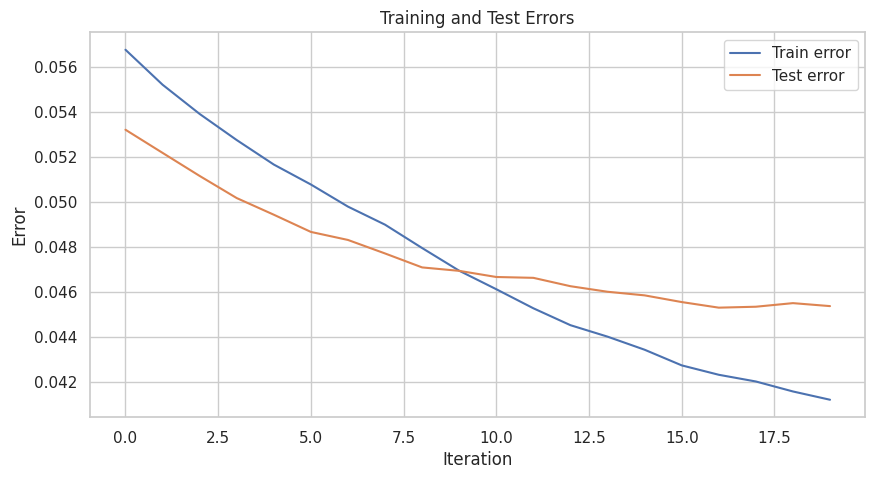

In [209]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler

# Загружаем и обрабатываем данные (пример с oot_data и df_initial)
X_oot = oot_data.drop(['target_conversion_rate', 'target_calls_qty_T1', 'datekey'], axis=1)
y_oot = oot_data['target_conversion_rate']
weights_oot = oot_data['target_calls_qty_T1']

# Определяем целевую переменную и признаки для оставшейся части набора данных
X = df_initial.drop(['target_conversion_rate', 'target_calls_qty_T1', 'datekey'], axis=1)
y = df_initial['target_conversion_rate']
weights = df_initial['target_calls_qty_T1']

# Преобразуем столбцы datetime в числовой формат
X = X.apply(lambda col: col.astype('int64') if col.dtype == 'datetime64[ns]' else col)
X_oot = X_oot.apply(lambda col: col.astype('int64') if col.dtype == 'datetime64[ns]' else col)

# Заменяем бесконечные значения на NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X_oot.replace([np.inf, -np.inf], np.nan, inplace=True)

# Заменяем пропущенные значения средними по столбцам
X.fillna(X.mean(), inplace=True)
X_oot.fillna(X_oot.mean(), inplace=True)

# Масштабируем данные с использованием RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Масштабируем OOT набор данных с использованием того же масштабировщика
X_oot_scaled = scaler.transform(X_oot)
X_oot_scaled = pd.DataFrame(X_oot_scaled, columns=X_oot.columns)

# Разделим данные на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_scaled, y, weights, test_size=0.4, random_state=42)

# Определим модель XGBRegressor
model = XGBRegressor(
    n_estimators=20,        # Количество итераций
    learning_rate=0.1,      # Скорость обучения
    max_depth=3,            # Глубина дерева
    objective='reg:squarederror',
    eval_metric='mae'
)

# Обучение модели
model.fit(
    X_train, y_train,
    sample_weight=weights_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Прогнозирование на тестовом и OOT наборах данных
y_pred_test = model.predict(X_test)

# Вычисление метрик производительности для тестового набора
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

# Прогнозирование на OOT наборе данных
y_pred_oot = model.predict(X_oot_scaled)

# Вычисление метрик производительности для OOT набора
mae_oot = mean_absolute_error(y_oot, y_pred_oot)
r2_oot = r2_score(y_oot, y_pred_oot)
mape_oot = mean_absolute_percentage_error(y_oot, y_pred_oot)

# Печать метрик производительности для тестового набора
print(f"XGB (Test) - Mean absolute error (MAE): {mae_test:.2f}")
print(f"XGB (Test) - R2 score: {r2_test:.2f}")
print(f"XGB (Test) - MAPE: {mape_test:.2f}%")

# Печать метрик производительности для OOT набора
print(f"XGB (OOT) - Mean absolute error (MAE): {mae_oot:.2f}")
print(f"XGB (OOT) - R2 score: {r2_oot:.2f}")
print(f"XGB (OOT) - MAPE: {mape_oot:.2f}%")

# Построение графика ошибок обучения и тестирования
eval_results = model.evals_result()
plt.figure(figsize=(10, 5))
plt.plot(eval_results['validation_0']['mae'], label='Train error')
plt.plot(eval_results['validation_1']['mae'], label='Test error')
plt.title('Training and Test Errors')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

###Выборка OOS

Попробуем отбирать в выборку OOS около 15% проектов. Затем обучим модель и посчитаем метрики на OOS.

В этом примере данные делятся на три части:

Обучающая выборка (Train set): использована для обучения модели.
Тестовая выборка (Test set): используется для промежуточной оценки модели во время обучения.
OOS выборка (Out of Sample set): используется для дополнительной оценки модели на данных по определенным проектам, которые модель ранее не видела. Выберем отдельно несколько проектов, так чтобы они составили 10-20% от общего числа проектов.
Результаты по каждой из выборок выводятся отдельно, что позволяет оценить производительность модели на разных выборках.

XGB (Test) - Mean absolute error (MAE): 0.04
XGB (Test) - R2 score: 0.49
XGB (Test) - MAPE: 2.97%
XGB (OOS) - Mean absolute error (MAE): 0.05
XGB (OOS) - R2 score: 0.46
XGB (OOS) - MAPE: 4.42%


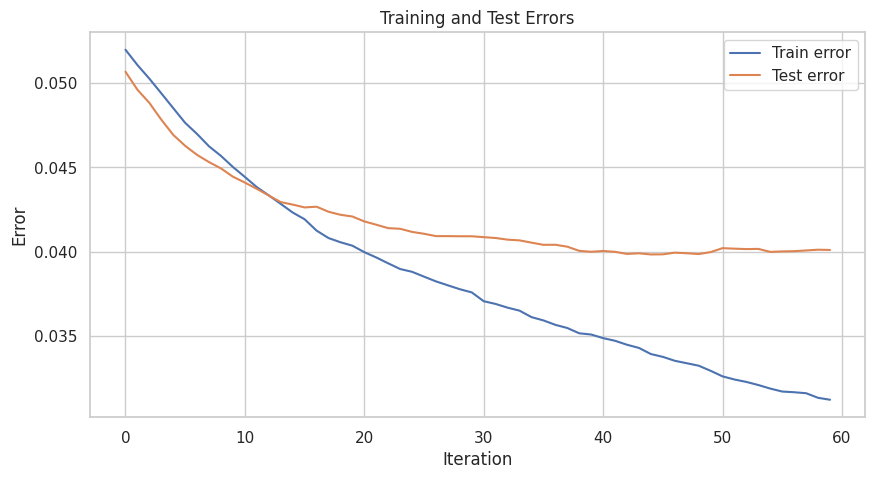

In [223]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler

# Load dataset (предполагаем, что df уже загружен)
# df = pd.read_csv('path_to_dataset.csv')

# Вычисляем общее количество уникальных project_id и выбираем 15% для OOS
unique_project_ids = df['project_id'].unique()
n_oos_projects = int(len(unique_project_ids) * 0.10)
oos_project_ids = np.random.choice(unique_project_ids, n_oos_projects, replace=False)

# Разделяем OOS (Out-of-Sample) данные
oos_data = df[df['project_id'].isin(oos_project_ids)]
X_oos = oos_data.drop(['target_conversion_rate', 'target_calls_qty_T1', 'datekey', 'project_id'], axis=1)
y_oos = oos_data['target_conversion_rate']
weights_oos = oos_data['target_calls_qty_T1']

# Оставшиеся данные для обучающего и тестового наборов
df_remaining = df[~df['project_id'].isin(oos_project_ids)]

# Определяем целевую переменную и признаки
X = df_remaining.drop(['target_conversion_rate', 'target_calls_qty_T1', 'datekey', 'project_id'], axis=1)
y = df_remaining['target_conversion_rate']
weights = df_remaining['target_calls_qty_T1']

# Преобразуем столбцы datetime в числовой формат
X = X.apply(lambda col: col.astype('int64') if col.dtype == 'datetime64[ns]' else col)
X_oos = X_oos.apply(lambda col: col.astype('int64') if col.dtype == 'datetime64[ns]' else col)

# Заменяем бесконечные значения на NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X_oos.replace([np.inf, -np.inf], np.nan, inplace=True)

# Заменяем пропущенные значения средними по столбцам
X.fillna(X.mean(), inplace=True)
X_oos.fillna(X_oos.mean(), inplace=True)

# Масштабируем данные с использованием RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_oos_scaled = scaler.transform(X_oos)
X_oos_scaled = pd.DataFrame(X_oos_scaled, columns=X_oos.columns)

# Разделяем данные на обучающие и тестовые наборы
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_scaled, y, weights, test_size=0.4, random_state=42)

# Определяем модель XGBRegressor
model = XGBRegressor(
    n_estimators=60,        # Количество итераций
    learning_rate=0.1,      # Скорость обучения
    max_depth=3,            # Глубина дерева
    objective='reg:squarederror',
    eval_metric='mae'
)

# Обучение модели
model.fit(
    X_train, y_train,
    sample_weight=weights_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Прогнозирование на тестовом и OOS наборах данных
y_pred_test = model.predict(X_test)
y_pred_oos = model.predict(X_oos_scaled)

# Вычисление метрик производительности для тестового набора
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

# Вычисление метрик производительности для OOS набора
mae_oos = mean_absolute_error(y_oos, y_pred_oos)
r2_oos = r2_score(y_oos, y_pred_oos)
mape_oos = mean_absolute_percentage_error(y_oos, y_pred_oos)

# Печать метрик производительности для тестового набора
print(f"XGB (Test) - Mean absolute error (MAE): {mae_test:.2f}")
print(f"XGB (Test) - R2 score: {r2_test:.2f}")
print(f"XGB (Test) - MAPE: {mape_test:.2f}%")

# Печать метрик производительности для OOS набора
print(f"XGB (OOS) - Mean absolute error (MAE): {mae_oos:.2f}")
print(f"XGB (OOS) - R2 score: {r2_oos:.2f}")
print(f"XGB (OOS) - MAPE: {mape_oos:.2f}%")

# Построение графика ошибок обучения и тестирования
eval_results = model.evals_result()
plt.figure(figsize=(10, 5))
plt.plot(eval_results['validation_0']['mae'], label='Train error')
plt.plot(eval_results['validation_1']['mae'], label='Test error')
plt.title('Training and Test Errors')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

XGB (Test) - Mean absolute error (MAE): 0.04
XGB (Test) - R2 score: 0.28
XGB (Test) - MAPE: 2.62%
XGB (OOS) - Mean absolute error (MAE): 0.06
XGB (OOS) - R2 score: 0.14
XGB (OOS) - MAPE: 2.02%


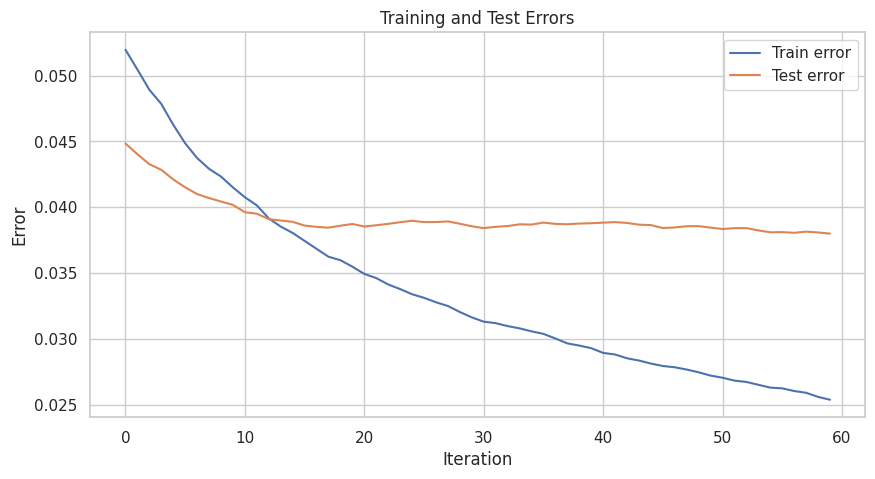

In [229]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler

# Load dataset (предполагаем, что df уже загружен)
# df = pd.read_csv('path_to_dataset.csv')

# Вычисляем общее количество уникальных project_id и выбираем 15% для OOS
unique_project_ids = df['project_id'].unique()
n_oos_projects = int(len(unique_project_ids) * 0.10)
oos_project_ids = np.random.choice(unique_project_ids, n_oos_projects, replace=False)

# Разделяем OOS (Out-of-Sample) данные
oos_data = df[df['project_id'].isin(oos_project_ids)]
X_oos = oos_data.drop(['target_conversion_rate', 'target_calls_qty_T1', 'datekey', 'project_id'], axis=1)
y_oos = oos_data['target_conversion_rate']
weights_oos = oos_data['target_calls_qty_T1']

# Оставшиеся данные для обучающего и тестового наборов
df_remaining = df[~df['project_id'].isin(oos_project_ids)]

# Определяем целевую переменную и признаки
X = df_remaining.drop(['target_conversion_rate', 'target_calls_qty_T1', 'datekey', 'project_id'], axis=1)
y = df_remaining['target_conversion_rate']
weights = df_remaining['target_calls_qty_T1']

# Преобразуем столбцы datetime в числовой формат
X = X.apply(lambda col: col.astype('int64') if col.dtype == 'datetime64[ns]' else col)
X_oos = X_oos.apply(lambda col: col.astype('int64') if col.dtype == 'datetime64[ns]' else col)

# Заменяем бесконечные значения на NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X_oos.replace([np.inf, -np.inf], np.nan, inplace=True)

# Заменяем пропущенные значения средними по столбцам
X.fillna(X.mean(), inplace=True)
X_oos.fillna(X_oos.mean(), inplace=True)

# Масштабируем данные с использованием RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_oos_scaled = scaler.transform(X_oos)
X_oos_scaled = pd.DataFrame(X_oos_scaled, columns=X_oos.columns)

# Разделяем данные на обучающие и тестовые наборы
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_scaled, y, weights, test_size=0.4, random_state=42)

# Определяем модель XGBRegressor
model = XGBRegressor(
    n_estimators=60,        # Количество итераций
    learning_rate=0.1,      # Скорость обучения
    max_depth=3,            # Глубина дерева
    objective='reg:squarederror',
    eval_metric='mae'
)

# Обучение модели
model.fit(
    X_train, y_train,
    sample_weight=weights_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Прогнозирование на тестовом и OOS наборах данных
y_pred_test = model.predict(X_test)
y_pred_oos = model.predict(X_oos_scaled)

# Вычисление метрик производительности для тестового набора
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

# Вычисление метрик производительности для OOS набора
mae_oos = mean_absolute_error(y_oos, y_pred_oos)
r2_oos = r2_score(y_oos, y_pred_oos)
mape_oos = mean_absolute_percentage_error(y_oos, y_pred_oos)

# Печать метрик производительности для тестового набора
print(f"XGB (Test) - Mean absolute error (MAE): {mae_test:.2f}")
print(f"XGB (Test) - R2 score: {r2_test:.2f}")
print(f"XGB (Test) - MAPE: {mape_test:.2f}%")

# Печать метрик производительности для OOS набора
print(f"XGB (OOS) - Mean absolute error (MAE): {mae_oos:.2f}")
print(f"XGB (OOS) - R2 score: {r2_oos:.2f}")
print(f"XGB (OOS) - MAPE: {mape_oos:.2f}%")

# Построение графика ошибок обучения и тестирования
eval_results = model.evals_result()
plt.figure(figsize=(10, 5))
plt.plot(eval_results['validation_0']['mae'], label='Train error')
plt.plot(eval_results['validation_1']['mae'], label='Test error')
plt.title('Training and Test Errors')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

## Shap - интерпретация признаков

In [69]:
!pip install -q shap
!pip install -q shap-selection

from shap_selection import feature_selection
feature_names = np.array(X_train.columns)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.2 MB/s eta 0:00:00


In [70]:
# please, use agnostic = True to use with any model...
# agnostic = False will only work with tree-based models
feature_order = feature_selection.shap_select(model, X_train, X_test, feature_names, agnostic=False)

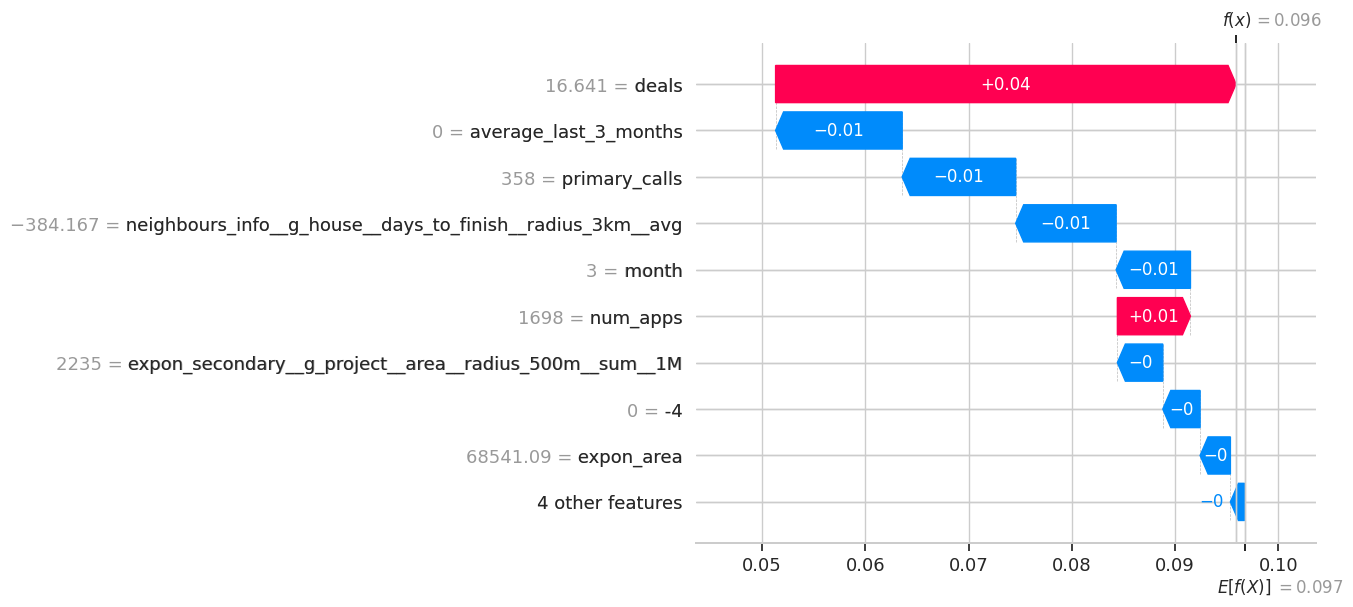

In [71]:
import shap

# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

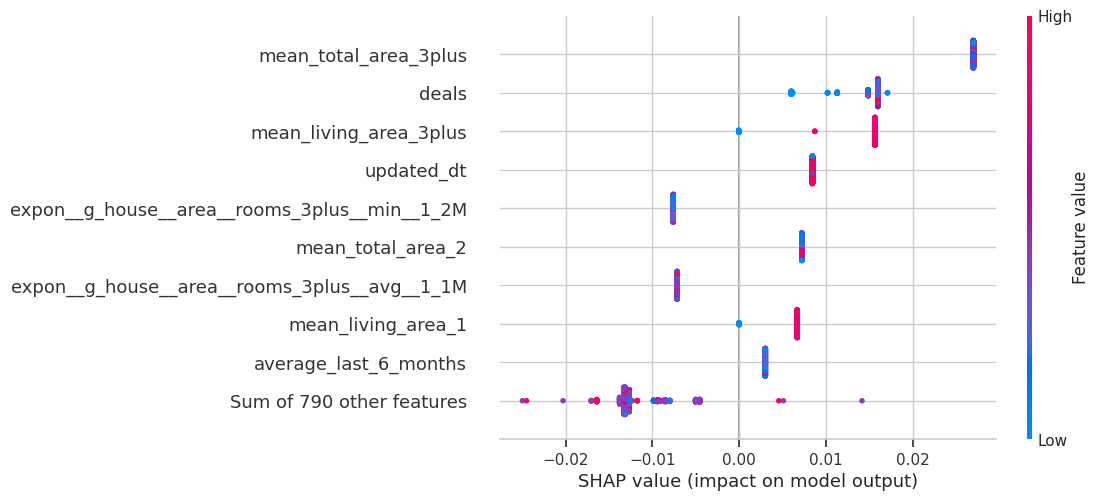

In [98]:
shap.plots.beeswarm(shap_values, max_display=10)